## Capstone Project: DDoS Detection (Module 20)
This notebook is part of my Capstone Project for the course Emeritus UC Berkeley Professional Certificate in Machine Learning and Artificial Intelligence. My project aims to build a machine learning model to detect Distributed Denial of Service (DDoS) attacks (Botnets) in network traffic data using the CTU-13 dataset. This notebook will focus on the code implementation. The final submission for Module 24 will include a more detailed report, additional explanations, and visualizations. I will also test the best model from this code against the other files in the CTU-13 dataset.

A detailed log of the code execution can be found in the [analysis log](./logs/analysis.log). All plots may also be viewed in [plots](./plots) folder.


## Section 1 Import Libraries, Implement Logging & Set Global Variables

In [19]:
# Section 1 Import Libraries, Implement Logging & Set Global Variables
# This section imports all necessary libraries, sets up logging, defines global variables, and ensures logs are stored properly.

import logging
import math
import os
import io
import time
import platform
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc
)

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# ---------------------------------------------------------------------
# Define paths and constants used globally
# ---------------------------------------------------------------------
LOG_FOLDER = "logs"
PLOTS_FOLDER = "plots"
DATA_FOLDER = "data"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Global color variables for consistent plots
COLOR_BACKGROUND = "#3498db"  # Blue
COLOR_BOTNET = "#e74c3c"      # Red
COLOR_NORMAL = "#2ecc71"      # Green

# ---------------------------------------------------------------------
# Helper function to clear the console
# ---------------------------------------------------------------------
def clear_console():
    """
    Clears the console/terminal in a cross-platform way.
    Works on Windows (cls) or *nix (clear).
    Might not affect some IDEs or Jupyter notebooks.
    """
    if platform.system().lower().startswith('win'):
        os.system('cls')
    else:
        os.system('clear')

# ---------------------------------------------------------------------
# Logging Configuration
# ---------------------------------------------------------------------
def log_and_print(message, log_obj, level='info'):
    """
    Logs a message using the provided logger object at the specified level,
    then prints the same message to the console for clarity.
    """
    if level == 'info':
        log_obj.info(message)
    elif level == 'warning':
        log_obj.warning(message)
    elif level == 'error':
        log_obj.error(message)
    print(message)

# Clear the console on each run
clear_console()

# Ensure logs folder exists
os.makedirs(LOG_FOLDER, exist_ok=True)

# Create the main logger
main_logger = logging.getLogger(__name__)
main_logger.setLevel(logging.INFO)

# Define paths for log files
log_path = os.path.join(LOG_FOLDER, "analysis.log")
error_log_path = os.path.join(LOG_FOLDER, "errors.log")
warning_log_path = os.path.join(LOG_FOLDER, "warnings.log")

# Remove old logs if they exist (so we start fresh each run)
for path in [log_path, error_log_path, warning_log_path]:
    if os.path.exists(path):
        os.remove(path)

# Remove existing handlers to avoid duplicates if the notebook is re-run
main_logger.handlers.clear()

# File handler for general info
file_handler = logging.FileHandler(log_path)
file_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
main_logger.addHandler(file_handler)

# Separate handler for errors only
error_handler = logging.FileHandler(error_log_path)
error_handler.setLevel(logging.ERROR)
error_formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
error_handler.setFormatter(error_formatter)
main_logger.addHandler(error_handler)

# Separate handler for warnings
warning_handler = logging.FileHandler(warning_log_path)
warning_handler.setLevel(logging.WARNING)
warning_formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
warning_handler.setFormatter(warning_formatter)
main_logger.addHandler(warning_handler)

# Test log message
log_and_print("Section 1 logging setup, imported libraries, & global variables\n", main_logger, level='info')

# This section set up library imports, global variables, logging, and prepared the environment for subsequent sections.


Section 1 logging setup, imported libraries, & global variables



## Section 2 Load & Explore Data



SECTION 2: LOAD & EXPLORE DATA

Successfully loaded DataFrame with shape: (107251, 15)
Sample rows of the DataFrame:

|    | StartTime                  |     Dur | Proto   | SrcAddr       |   Sport | Dir   | DstAddr       |   Dport | State   |   sTos |   dTos |   TotPkts |   TotBytes |   SrcBytes | Label                           |
|---:|:---------------------------|--------:|:--------|:--------------|--------:|:------|:--------------|--------:|:--------|-------:|-------:|----------:|-----------:|-----------:|:--------------------------------|
|  0 | 2011/08/18 15:40:53.826372 | 2.98325 | tcp     | 76.76.172.248 |   63577 | ->    | 147.32.84.229 |   13363 | SR_SA   |      0 |      0 |         3 |        184 |        122 | flow=Background-TCP-Established |
|  1 | 2011/08/18 15:40:55.435494 | 2.90603 | tcp     | 76.76.172.248 |   63580 | ->    | 147.32.84.229 |     443 | SR_SA   |      0 |      0 |         3 |        184 |        122 | flow=Background-TCP-Established |
|  2 | 2011/08/1

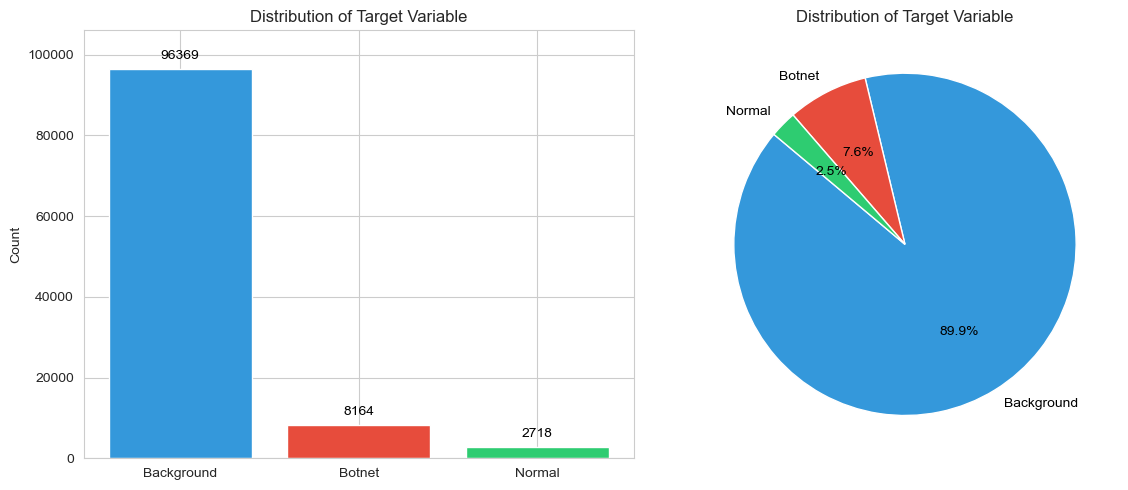

Checking for missing values & describing basic stats...

Missing values per column:

|            |     0 |
|:-----------|------:|
| StartTime  |     0 |
| Dur        |     0 |
| Proto      |     0 |
| SrcAddr    |     0 |
| Sport      |   463 |
| Dir        |     0 |
| DstAddr    |     0 |
| Dport      |  7900 |
| State      |    91 |
| sTos       |   980 |
| dTos       | 16959 |
| TotPkts    |     0 |
| TotBytes   |     0 |
| SrcBytes   |     0 |
| Label      |     0 |
| LabelGroup |     0 |

Explanation: Some columns (Sport, Dport, sTos, dTos, State) may be missing if not recorded.

Basic statistics of all columns:

|        | StartTime                  |           Dur | Proto   | SrcAddr       |   Sport | Dir    | DstAddr     |   Dport | State   |           sTos |           dTos |     TotPkts |         TotBytes |         SrcBytes | Label                           | LabelGroup   |
|:-------|:---------------------------|--------------:|:--------|:--------------|--------:|:-------|:--

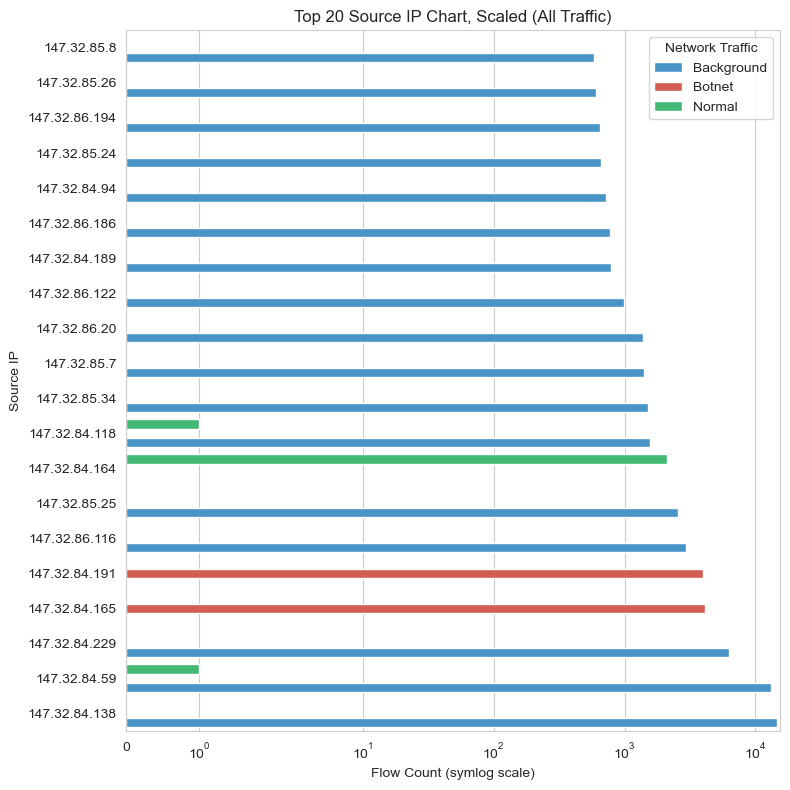

Top 20 Source IP distribution counts: {'Background': 51525, 'Botnet': 8157, 'Normal': 2115}
Creating top 20 Source IP Chart, Scaled (Normal + Botnet Traffic)

S2 - Top 20 source IP chart (Botnet+Normal) saved to plots/S2_top_20_src_ips_botnet_normal_scaled.png


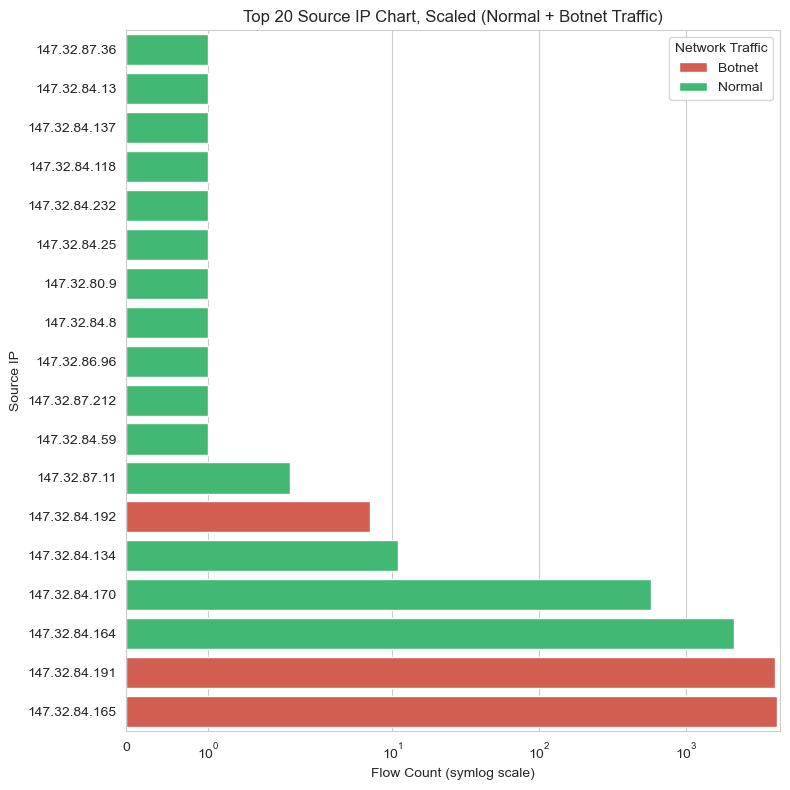

Creating Top 20 Destination IP Chart, Scaled (All Traffic)

S2 - Top 20 destination IP chart (All Traffic) saved to plots/S2_top_20_dst_ips_all_scaled.png


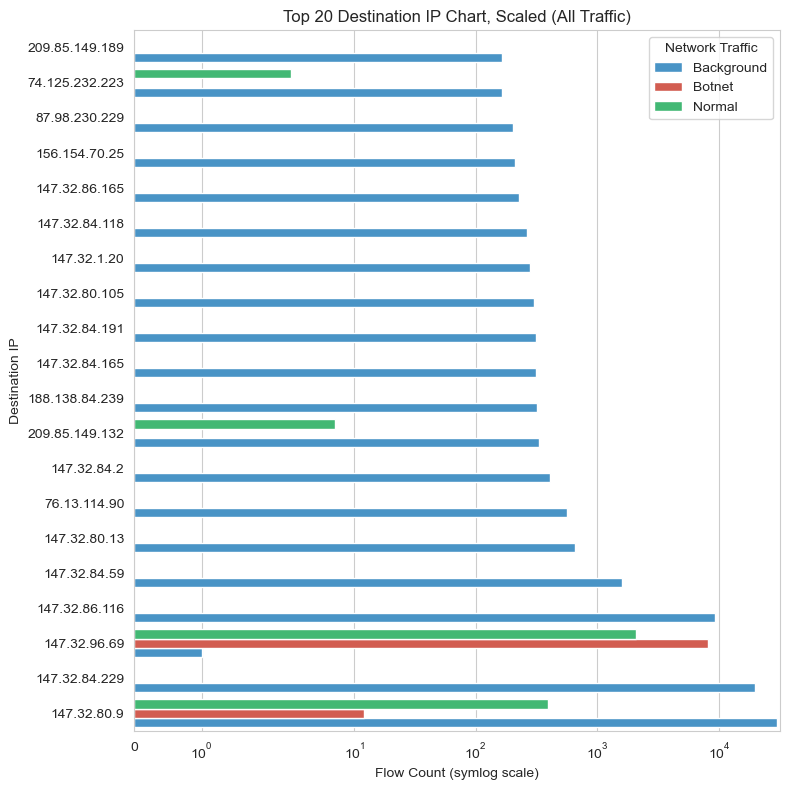

Top 20 Destination IP distribution counts: {'Background': 65740, 'Botnet': 8155, 'Normal': 2498}
Creating Top 20 Destination IP Chart, Scaled (Normal + Botnet Traffic)

S2 - Top 20 destination IP chart (Botnet+Normal) saved to plots/S2_top_20_dst_ips_botnet_normal_scaled.png


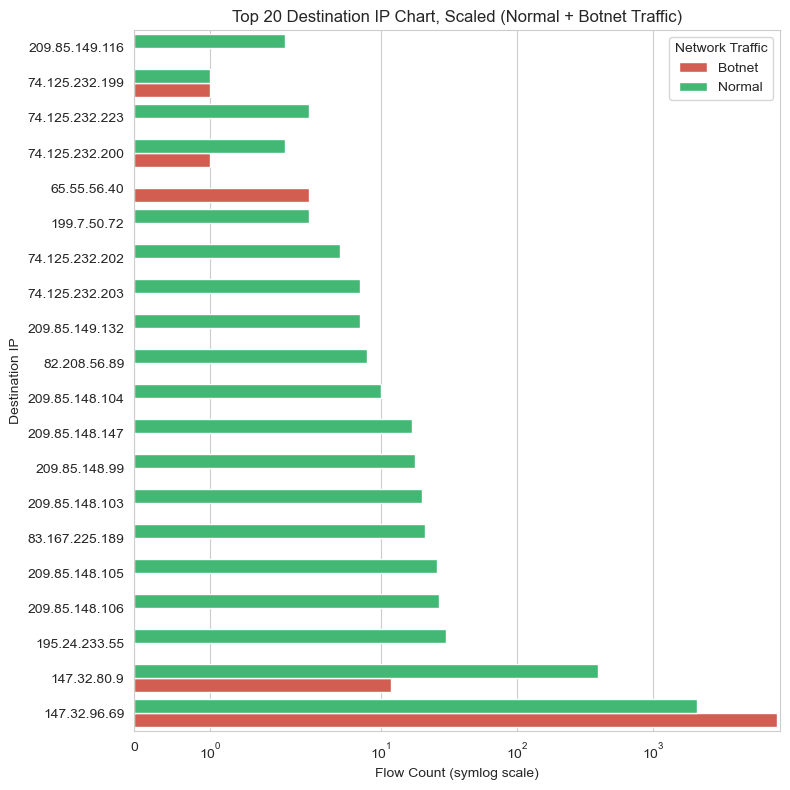

Plotting time-based packets (All Traffic)...

Earliest timestamp: 2011-08-18 15:39:35.087798
Latest timestamp: 2011-08-18 15:55:46.379941
Total capture duration: 0 days 00:16:11.292143

S2 - Time-based packets (All Traffic) saved to plots/S2_time_based_totpkts_all_scaled.png


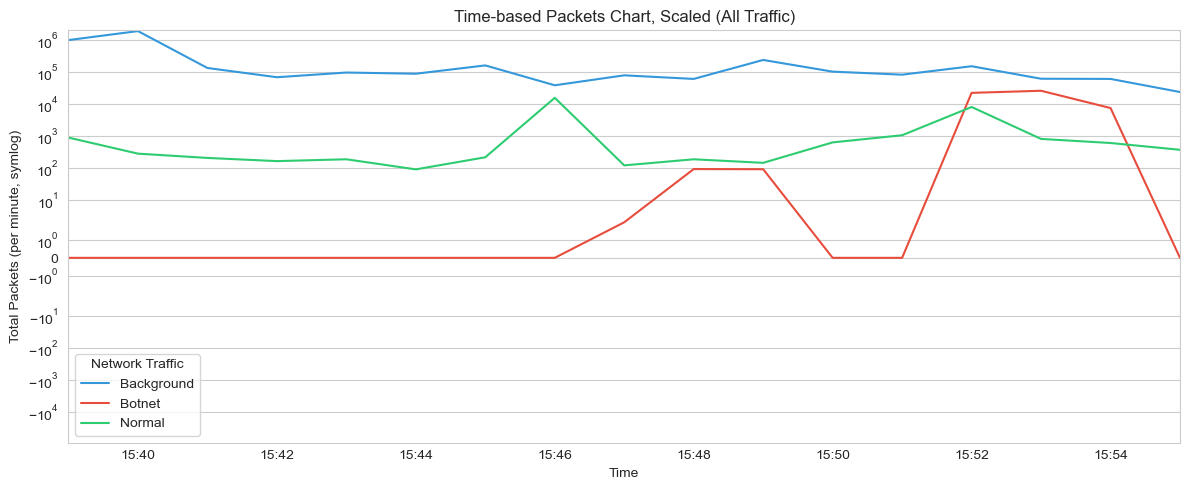

Time-based packet stats (sum per minute): {'count': 17.0, 'mean': 258509.5294117647, 'std': 474000.8773293723, 'min': 23881.0, '25%': 68433.0, '50%': 87869.0, '75%': 159754.0, 'max': 1885782.0}
Creating time-based average duration chart, scaled (All Traffic)...

S2 - Time-based average Dur (All Traffic) saved to plots/S2_time_based_avg_dur_all_scaled.png


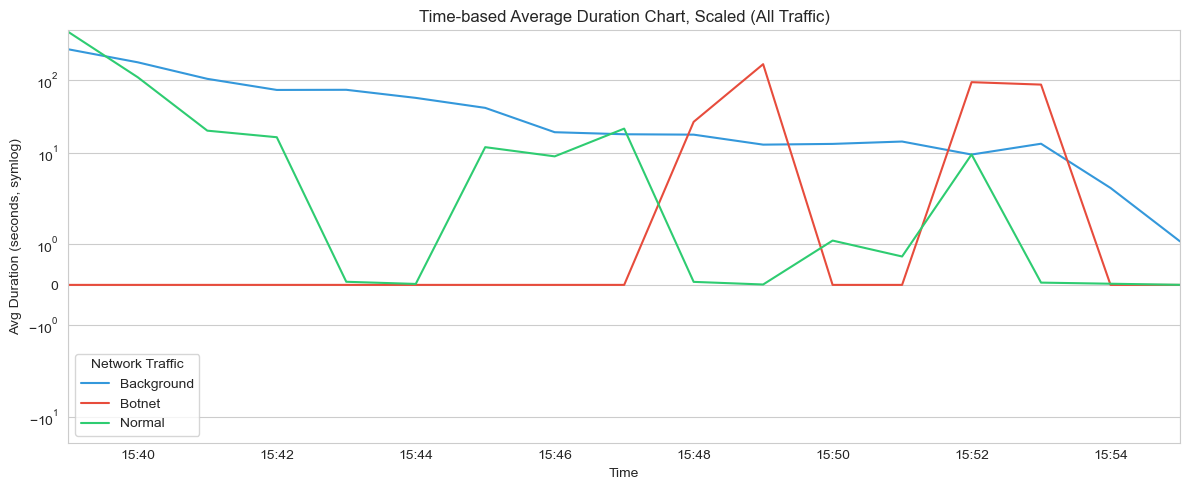

Time-based average duration stats (mean per minute): {'count': 51.0, 'mean': 37.904090179296055, 'std': 79.84021259408507, 'min': 0.0, '25%': 0.0009210759717314487, '50%': 9.488129102349971, '75%': 24.07293478125, 'max': 454.9645861666667}

| Category  | Metric                                                    |                                          Value |
|:--------- |:--------------------------------------------------------- |----------------------------------------------:|
| Botnet    | Number of unique Botnet source IPs                        | 3                          |
| Botnet    | Number of unique Botnet Targets IPs                       | 9                          |
| Botnet    | Number of Botnet sockets (SrcAddr, Sport, DstAddr, Dport) | 8155                             |
| Normal    | Number of Normal Sockets                                  | 613                             |
| Botnet    | Total Botnet packets                                      | 55504            

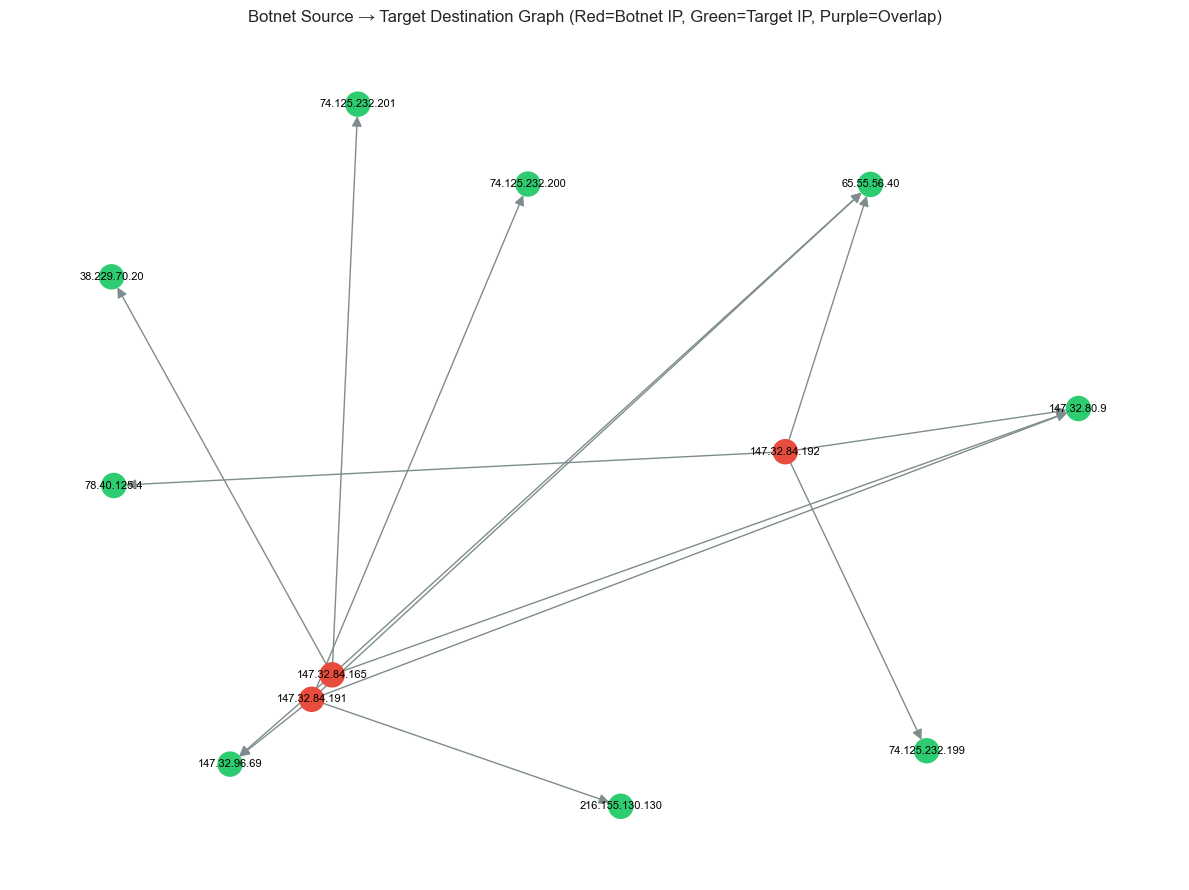

In [20]:
# Section 2 Load & Explore Data
# This section reads the CSV data, prints basic info, categorizes labels, and creates summary plots.

log_and_print("\n\nSECTION 2: LOAD & EXPLORE DATA\n", main_logger, level='info')

file_name = "11-Rbot-20110818-2.binetflow.csv"
file_path = os.path.join(DATA_FOLDER, file_name)

try:
    df = pd.read_csv(file_path)
    loaded_msg = f"Successfully loaded DataFrame with shape: {df.shape}"
    log_and_print(loaded_msg, main_logger, level='info')
except FileNotFoundError:
    error_msg = "File not found. Please check the path."
    log_and_print(error_msg, main_logger, level='error')
    raise

log_and_print("Sample rows of the DataFrame:", main_logger, level='info')
df_head_markdown = df.head().to_markdown()
log_and_print(f"\n{df_head_markdown}\n", main_logger, level='info')

log_and_print("Data types:", main_logger, level='info')
buf = io.StringIO()
df.info(buf=buf)
info_str = buf.getvalue()
log_and_print(f"\n{info_str}\n", main_logger, level='info')

# Group 'Label' into broad categories: Background, Botnet, or Normal
if 'Label' in df.columns:
    log_and_print("Grouping 'Label' into Background, Botnet, or Normal...\n", main_logger, level='info')

    def aggregate_label(x):
        x_lower = str(x).lower()
        if "background" in x_lower:
            return "Background"
        elif "botnet" in x_lower:
            return "Botnet"
        else:
            return "Normal"

    df["LabelGroup"] = df["Label"].apply(aggregate_label)

    # Color map
    color_map = {
        "Background": COLOR_BACKGROUND,
        "Botnet": COLOR_BOTNET,
        "Normal": COLOR_NORMAL
    }
    categories = ["Background", "Botnet", "Normal"]

    # Compute label distribution
    label_counts = df["LabelGroup"].value_counts().reindex(categories, fill_value=0)
    total_counts = label_counts.sum()

    # Log the distribution
    counts_dict = label_counts.to_dict()
    log_and_print(f"Distribution of LabelGroup: {counts_dict}", main_logger, level='info')

    # Bar & Pie Plot
    fig, (ax_bar, ax_pie) = plt.subplots(ncols=2, figsize=(12, 5))
    max_count = label_counts.values.max()
    y_lim_top = max_count * 1.1

    bars = ax_bar.bar(
        label_counts.index,
        label_counts.values,
        color=[color_map[cat] for cat in label_counts.index]
    )
    ax_bar.set_title("Distribution of Target Variable")
    ax_bar.set_ylabel("Count")
    ax_bar.set_ylim(top=y_lim_top)

    # Annotate bar heights
    for bar, cat in zip(bars, label_counts.index):
        height = bar.get_height()
        offset = max_count * 0.02
        ax_bar.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + offset,
            str(height),
            ha='center',
            va='bottom',
            color='black'
        )

    wedges, text_labels, autotexts = ax_pie.pie(
        label_counts.values,
        labels=label_counts.index,
        colors=[color_map[cat] for cat in label_counts.index],
        autopct='%1.1f%%',
        startangle=140,
        textprops={'color': 'black'}
    )
    ax_pie.set_title("Distribution of Target Variable")

    plt.tight_layout()
    combined_plot_filename = os.path.join(PLOTS_FOLDER, "S2_target_distribution_combined.png")
    plt.savefig(combined_plot_filename, dpi=300)
    log_and_print(f"S2 - Combined bar/pie chart saved to {combined_plot_filename}", main_logger, level='info')
    plt.show()

    # Check missingness
    log_and_print("Checking for missing values & describing basic stats...\n", main_logger, level='info')
    missing_counts = df.isna().sum()
    missing_table_md = missing_counts.to_markdown()
    log_and_print(f"Missing values per column:\n\n{missing_table_md}\n", main_logger, level='info')

    log_and_print(
        "Explanation: Some columns (Sport, Dport, sTos, dTos, State) may be missing if not recorded.\n",
        main_logger,
        level='info'
    )

    stats_md = df.describe(include='all').to_markdown()
    log_and_print(f"Basic statistics of all columns:\n\n{stats_md}\n", main_logger, level='info')

    # ---------------------------------------------------------------------
    # Top 20 Source IP (All Traffic vs. Botnet+Normal)
    # ---------------------------------------------------------------------
    if "SrcAddr" in df.columns:
        log_and_print("Creating top 20 Source IP Chart, Scaled (All Traffic)\n", main_logger, level='info')
        top_src_series = df["SrcAddr"].value_counts().head(20)
        df_top_src = df[df["SrcAddr"].isin(top_src_series.index)].copy()
        df_top_src.rename(columns={"LabelGroup": "Network Traffic"}, inplace=True)
        group_counts_src = df_top_src.groupby(["SrcAddr", "Network Traffic"]).size().reset_index(name="Count")

        ip_order = group_counts_src.groupby("SrcAddr")["Count"].sum().sort_values(ascending=False).index

        plt.figure(figsize=(8, 8))
        sns.barplot(
            data=group_counts_src,
            y="SrcAddr",
            x="Count",
            hue="Network Traffic",
            order=ip_order,
            hue_order=categories,
            palette=[color_map[c] for c in categories if c in df_top_src["Network Traffic"].unique()],
            orient='h'
        )
        plt.gca().invert_yaxis()
        plt.xscale('symlog')
        plt.title("Top 20 Source IP Chart, Scaled (All Traffic)")
        plt.ylabel("Source IP")
        plt.xlabel("Flow Count (symlog scale)")
        plt.tight_layout()

        top_src_file = os.path.join(PLOTS_FOLDER, "S2_top_20_src_ips_all_scaled.png")
        plt.savefig(top_src_file, dpi=300)
        log_and_print(f"S2 - Top 20 source IP chart (All Traffic) saved to {top_src_file}", main_logger, level='info')
        plt.show()

        # Numeric distribution among these top sources
        counts_info = group_counts_src.groupby("Network Traffic")["Count"].sum().to_dict()
        log_and_print(f"Top 20 Source IP distribution counts: {counts_info}", main_logger, level='info')

        # Botnet + Normal only
        df_sb = df[df["LabelGroup"].isin(["Botnet", "Normal"])].copy()
        if not df_sb.empty:
            log_and_print("Creating top 20 Source IP Chart, Scaled (Normal + Botnet Traffic)\n", main_logger, level='info')
            top_src_sb = df_sb["SrcAddr"].value_counts().head(20).index
            df_sb_top = df_sb[df_sb["SrcAddr"].isin(top_src_sb)].copy()
            df_sb_top.rename(columns={"LabelGroup": "Network Traffic"}, inplace=True)

            group_counts_sb = df_sb_top.groupby(["SrcAddr", "Network Traffic"]).size().reset_index(name="Count")
            ip_order_sb = group_counts_sb.groupby("SrcAddr")["Count"].sum().sort_values(ascending=False).index

            plt.figure(figsize=(8, 8))
            sns.barplot(
                data=group_counts_sb,
                y="SrcAddr",
                x="Count",
                hue="Network Traffic",
                order=ip_order_sb,
                hue_order=["Botnet", "Normal"],
                palette=[color_map["Botnet"], color_map["Normal"]],
                orient='h'
            )
            plt.gca().invert_yaxis()
            plt.xscale('symlog')
            plt.title("Top 20 Source IP Chart, Scaled (Normal + Botnet Traffic)")
            plt.ylabel("Source IP")
            plt.xlabel("Flow Count (symlog scale)")
            plt.tight_layout()

            top_src_bn_file = os.path.join(PLOTS_FOLDER, "S2_top_20_src_ips_botnet_normal_scaled.png")
            plt.savefig(top_src_bn_file, dpi=300)
            log_and_print(
                f"S2 - Top 20 source IP chart (Botnet+Normal) saved to {top_src_bn_file}",
                main_logger,
                level='info'
            )
            plt.show()

    # ---------------------------------------------------------------------
    # Top 20 Destination IP (All Traffic vs. Botnet+Normal)
    # ---------------------------------------------------------------------
    if "DstAddr" in df.columns:
        log_and_print("Creating Top 20 Destination IP Chart, Scaled (All Traffic)\n", main_logger, level='info')
        top_dst_series = df["DstAddr"].value_counts().head(20)
        df_top_dst = df[df["DstAddr"].isin(top_dst_series.index)].copy()
        df_top_dst.rename(columns={"LabelGroup": "Network Traffic"}, inplace=True)

        group_counts_dst = df_top_dst.groupby(["DstAddr", "Network Traffic"]).size().reset_index(name="Count")
        ip_order_dst = (
            group_counts_dst.groupby("DstAddr")["Count"]
            .sum()
            .sort_values(ascending=False)
            .index
        )

        plt.figure(figsize=(8, 8))
        sns.barplot(
            data=group_counts_dst,
            y="DstAddr",
            x="Count",
            hue="Network Traffic",
            order=ip_order_dst,
            hue_order=categories,
            palette=[color_map[c] for c in categories if c in df_top_dst["Network Traffic"].unique()],
            orient='h'
        )
        plt.gca().invert_yaxis()
        plt.xscale('symlog')
        plt.title("Top 20 Destination IP Chart, Scaled (All Traffic)")
        plt.ylabel("Destination IP")
        plt.xlabel("Flow Count (symlog scale)")
        plt.tight_layout()

        top_dst_file = os.path.join(PLOTS_FOLDER, "S2_top_20_dst_ips_all_scaled.png")
        plt.savefig(top_dst_file, dpi=300)
        log_and_print(
            f"S2 - Top 20 destination IP chart (All Traffic) saved to {top_dst_file}",
            main_logger,
            level='info'
        )
        plt.show()

        # Numeric distribution among these top destinations
        counts_info_dst = group_counts_dst.groupby("Network Traffic")["Count"].sum().to_dict()
        log_and_print(f"Top 20 Destination IP distribution counts: {counts_info_dst}", main_logger, level='info')

        # Botnet + Normal only
        df_dst_bn = df[df["LabelGroup"].isin(["Botnet", "Normal"])].copy()
        if not df_dst_bn.empty:
            log_and_print("Creating Top 20 Destination IP Chart, Scaled (Normal + Botnet Traffic)\n", main_logger, level='info')
            top_dst_bn = df_dst_bn["DstAddr"].value_counts().head(20).index
            df_dst_bn_top = df_dst_bn[df_dst_bn["DstAddr"].isin(top_dst_bn)].copy()
            df_dst_bn_top.rename(columns={"LabelGroup": "Network Traffic"}, inplace=True)

            group_counts_dst_bn = df_dst_bn_top.groupby(["DstAddr", "Network Traffic"]).size().reset_index(name="Count")
            ip_order_bn = (
                group_counts_dst_bn.groupby("DstAddr")["Count"]
                .sum()
                .sort_values(ascending=False)
                .index
            )

            plt.figure(figsize=(8, 8))
            sns.barplot(
                data=group_counts_dst_bn,
                y="DstAddr",
                x="Count",
                hue="Network Traffic",
                order=ip_order_bn,
                hue_order=["Botnet", "Normal"],
                palette=[color_map["Botnet"], color_map["Normal"]],
                orient='h'
            )
            plt.gca().invert_yaxis()
            plt.xscale('symlog')
            plt.title("Top 20 Destination IP Chart, Scaled (Normal + Botnet Traffic)")
            plt.ylabel("Destination IP")
            plt.xlabel("Flow Count (symlog scale)")
            plt.tight_layout()

            top_dst_bn_file = os.path.join(PLOTS_FOLDER, "S2_top_20_dst_ips_botnet_normal_scaled.png")
            plt.savefig(top_dst_bn_file, dpi=300)
            log_and_print(
                f"S2 - Top 20 destination IP chart (Botnet+Normal) saved to {top_dst_bn_file}",
                main_logger,
                level='info'
            )
            plt.show()

    # ---------------------------------------------------------------------
    # Time-based Packets (All Traffic)
    # ---------------------------------------------------------------------
    if "StartTime" in df.columns and "TotPkts" in df.columns:
        log_and_print("Plotting time-based packets (All Traffic)...\n", main_logger, level='info')
        df["ParsedTime"] = pd.to_datetime(df["StartTime"], errors='coerce')

        min_time = df["ParsedTime"].min()
        max_time = df["ParsedTime"].max()
        time_duration = max_time - min_time
        log_and_print(
            f"Earliest timestamp: {min_time}\nLatest timestamp: {max_time}\nTotal capture duration: {time_duration}\n",
            main_logger,
            level='info'
        )

        df_pt_all = df.rename(columns={"LabelGroup": "Network Traffic"}).copy()
        df_line_all = (
            df_pt_all
            .groupby([pd.Grouper(key="ParsedTime", freq="Min"), "Network Traffic"])["TotPkts"]
            .sum()
            .unstack(fill_value=0)
        )

        plt.figure(figsize=(12, 5))
        df_line_all.plot(
            ax=plt.gca(),
            color=[COLOR_BACKGROUND, COLOR_BOTNET, COLOR_NORMAL],
            title="Time-based Packets Chart, Scaled (All Traffic)"
        )
        plt.yscale('symlog')
        plt.xlabel("Time")
        plt.ylabel("Total Packets (per minute, symlog)")
        plt.tight_layout()
        time_plot_file = os.path.join(PLOTS_FOLDER, "S2_time_based_totpkts_all_scaled.png")
        plt.savefig(time_plot_file, dpi=300)
        log_and_print(f"S2 - Time-based packets (All Traffic) saved to {time_plot_file}", main_logger, level='info')
        plt.show()

        per_min_counts = df_line_all.sum(axis=1).describe().to_dict()
        log_and_print(f"Time-based packet stats (sum per minute): {per_min_counts}", main_logger, level='info')

    # ---------------------------------------------------------------------
    # Time-based Average Duration (All Traffic)
    # ---------------------------------------------------------------------
    if "Dur" in df.columns and "ParsedTime" in df.columns:
        log_and_print("Creating time-based average duration chart, scaled (All Traffic)...\n", main_logger, level='info')

        df_dur_all = df.rename(columns={"LabelGroup": "Network Traffic"}).copy()
        df_line_dur_all = (
            df_dur_all
            .groupby([pd.Grouper(key="ParsedTime", freq="Min"), "Network Traffic"])["Dur"]
            .mean()
            .unstack(fill_value=0)
        )

        plt.figure(figsize=(12, 5))
        df_line_dur_all.plot(
            ax=plt.gca(),
            color=[COLOR_BACKGROUND, COLOR_BOTNET, COLOR_NORMAL],
            title="Time-based Average Duration Chart, Scaled (All Traffic)"
        )
        plt.yscale('symlog')
        plt.xlabel("Time")
        plt.ylabel("Avg Duration (seconds, symlog)")
        plt.tight_layout()
        dur_all_file = os.path.join(PLOTS_FOLDER, "S2_time_based_avg_dur_all_scaled.png")
        plt.savefig(dur_all_file, dpi=300)
        log_and_print(f"S2 - Time-based average Dur (All Traffic) saved to {dur_all_file}", main_logger, level='info')
        plt.show()

        dur_stats = df_line_dur_all.stack().describe().to_dict()
        log_and_print(f"Time-based average duration stats (mean per minute): {dur_stats}", main_logger, level='info')

    # ---------------------------------------------------------------------
    # Botnet vs Normal Stats + Botnet Graph
    # ---------------------------------------------------------------------
    botnet_df = df[df["LabelGroup"] == "Botnet"].copy()
    normal_df = df[df["LabelGroup"] == "Normal"].copy()

    # Count source IPs, target IPs, sockets, etc.
    botnet_source_ips = botnet_df["SrcAddr"].nunique()
    botnet_target_ips = botnet_df["DstAddr"].nunique()
    botnet_sockets = botnet_df[["SrcAddr", "Sport", "DstAddr", "Dport"]].drop_duplicates().shape[0]
    total_botnet_packets = botnet_df["TotPkts"].sum()

    botnet_nonzero = botnet_df[botnet_df["TotPkts"] > 0].copy()
    if not botnet_nonzero.empty:
        botnet_nonzero["PacketSize"] = botnet_nonzero["TotBytes"] / botnet_nonzero["TotPkts"]
        botnet_pkt_min = botnet_nonzero["PacketSize"].min()
        botnet_pkt_mean = botnet_nonzero["PacketSize"].mean()
        botnet_pkt_max = botnet_nonzero["PacketSize"].max()
    else:
        botnet_pkt_min, botnet_pkt_mean, botnet_pkt_max = 0, 0, 0

    if not botnet_df.empty:
        botnet_dur_min = botnet_df["Dur"].min()
        botnet_dur_mean = botnet_df["Dur"].mean()
        botnet_dur_max = botnet_df["Dur"].max()
    else:
        botnet_dur_min, botnet_dur_mean, botnet_dur_max = 0, 0, 0

    normal_sockets = normal_df[["SrcAddr", "Sport", "DstAddr", "Dport"]].drop_duplicates().shape[0] if not normal_df.empty else 0
    total_normal_packets = normal_df["TotPkts"].sum() if not normal_df.empty else 0

    normal_nonzero = normal_df[normal_df["TotPkts"] > 0].copy()
    if not normal_nonzero.empty:
        normal_nonzero["PacketSize"] = normal_nonzero["TotBytes"] / normal_nonzero["TotPkts"]
        normal_pkt_min = normal_nonzero["PacketSize"].min()
        normal_pkt_mean = normal_nonzero["PacketSize"].mean()
        normal_pkt_max = normal_nonzero["PacketSize"].max()
    else:
        normal_pkt_min, normal_pkt_mean, normal_pkt_max = 0, 0, 0

    if not normal_df.empty:
        normal_dur_min = normal_df["Dur"].min()
        normal_dur_mean = normal_df["Dur"].mean()
        normal_dur_max = normal_df["Dur"].max()
    else:
        normal_dur_min, normal_dur_mean, normal_dur_max = 0, 0, 0

    # Create a stats table for logging
    stats_table = f"""
| Category  | Metric                                                    |                                          Value |
|:--------- |:--------------------------------------------------------- |----------------------------------------------:|
| Botnet    | Number of unique Botnet source IPs                        | {botnet_source_ips}                          |
| Botnet    | Number of unique Botnet Targets IPs                       | {botnet_target_ips}                          |
| Botnet    | Number of Botnet sockets (SrcAddr, Sport, DstAddr, Dport) | {botnet_sockets}                             |
| Normal    | Number of Normal Sockets                                  | {normal_sockets}                             |
| Botnet    | Total Botnet packets                                      | {total_botnet_packets}                       |
| Normal    | Total Normal Packets                                      | {total_normal_packets}                       |
| Botnet    | Botnet Packet Size (bytes) [min, mean, max]               | [{botnet_pkt_min:.2f}, {botnet_pkt_mean:.2f}, {botnet_pkt_max:.2f}]  |
| Normal    | Normal Packet Size (bytes) [min, mean, max]               | [{normal_pkt_min:.2f}, {normal_pkt_mean:.2f}, {normal_pkt_max:.2f}] |
| Botnet    | Botnet Duration (seconds) [min, mean, max]                | [{botnet_dur_min:.2f}, {botnet_dur_mean:.2f}, {botnet_dur_max:.2f}] |
| Normal    | Normal Duration (seconds) [min, mean, max]                | [{normal_dur_min:.2f}, {normal_dur_mean:.2f}, {normal_dur_max:.2f}] |
"""
    log_and_print(stats_table, main_logger, level='info')

    # Create a Botnet Source → Destination graph
    log_and_print("\nCreating a Botnet Source→Target Destination Graph\n", main_logger, level='info')

    botnet_exchanges = (
        botnet_df
        .groupby(["SrcAddr", "DstAddr"])
        .size()
        .reset_index(name="FlowCount")
    )

    if botnet_exchanges.empty:
        log_and_print("No Botnet flows found for a source→destination graph.", main_logger, level='warning')
    else:
        G = nx.DiGraph()
        for _, row in botnet_exchanges.iterrows():
            src = row["SrcAddr"]
            dst = row["DstAddr"]
            count = row["FlowCount"]
            G.add_edge(src, dst, weight=count)

        src_nodes = set(botnet_exchanges["SrcAddr"])
        dst_nodes = set(botnet_exchanges["DstAddr"])

        node_colors = []
        for node in G.nodes():
            if node in src_nodes and node in dst_nodes:
                # If a node is both in src and dst sets, color it differently
                node_colors.append("#9b59b6")  # Purple
            elif node in src_nodes:
                node_colors.append(COLOR_BOTNET)
            else:
                node_colors.append(COLOR_NORMAL)

        pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
        plt.figure(figsize=(12, 9))

        nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
        nx.draw_networkx_edges(G, pos, edge_color="#7f8c8d", arrows=True, arrowsize=15)
        nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

        plt.title("Botnet Source → Target Destination Graph (Red=Botnet IP, Green=Target IP, Purple=Overlap)")
        plt.axis("off")
        plt.tight_layout()

        botnet_graph_file = os.path.join(PLOTS_FOLDER, "S2_botnet_src_dist_plot.png")
        plt.savefig(botnet_graph_file, dpi=300)
        log_and_print(f"\n{botnet_graph_file}\n", main_logger, level='info')
        plt.show()

else:
    log_and_print("WARNING: 'Label' column not found in DataFrame.", main_logger, level='warning')

# This section finished loading and exploring the dataset, created distribution plots, and summarized key stats about Botnet vs Normal flows.

## Section 3 Basic Data Cleaning & Feature Engineering



SECTION 3 (Enhanced): BASIC DATA CLEANING & FEATURE ENGINEERING

Created DurCategory feature. Distribution: {'very_short': 10106, 'long': 755, 'medium': 13, 'short': 8}
Created BytePktRatio feature. Basic stats: {'count': 10882.0, 'mean': 822.1099264102124, 'std': 421.45060727454836, 'min': 60.0, '25%': 292.0, '50%': 1066.0, '75%': 1066.0, 'max': 1066.0}
Enhanced Feature matrix shape: (10882, 17), Target vector shape: (10882,)
Showing the first few rows of the enhanced DataFrame:


|     |     Dur | Proto   | Dir   | State   | SrcAddr       | DstAddr        | SportRange   | DportRange   |   TotPkts |   TotBytes |   SrcBytes |   BytesPerSecond |   PktsPerSecond |   BytePktRatio |   SrcAddrEntropy |   DstAddrEntropy | DurCategory   |   Botnet |
|----:|--------:|:--------|:------|:--------|:--------------|:---------------|:-------------|:-------------|----------:|-----------:|-----------:|-----------------:|----------------:|---------------:|-----------------:|-----------------:|:------

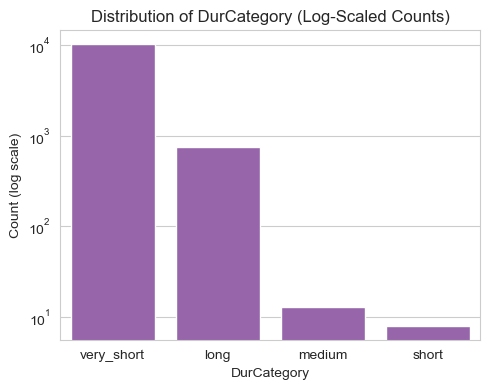


**Plot Name:** Distribution of BytePktRatio

Stats for plotted feature:

| Metric | Value |
|---|---|
| count | 10882.0 |
| mean | 822.1099264102124 |
| std | 421.45060727454836 |
| min | 60.0 |
| 25% | 292.0 |
| 50% | 1066.0 |
| 75% | 1066.0 |
| max | 1066.0 |

data: 60.0
Applied log scale for this plot

BytePktRatio box plot saved to plots/S3_bytepktratio_boxplot.png


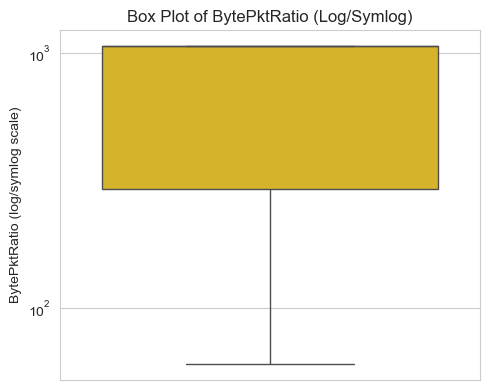


**Plot Name:** Distribution of BytesPerSecond

Stats for plotted feature:

| Metric | Value |
|---|---|
| count | 10882.0 |
| mean | 65707.63308488764 |
| std | 195364.19446829928 |
| min | 0.0 |
| 25% | 0.0 |
| 50% | 0.0 |
| 75% | 243.2164971812862 |
| max | 1748538.0116959063 |

data: 0.0
Applied symlog scale for this plot

Plot for BytesPerSecond saved to plots/S3_bytes_per_second_dist.png


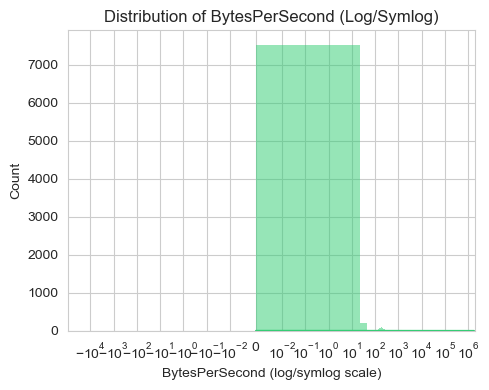


**Plot Name:** Distribution of PktsPerSecond

Stats for plotted feature:

| Metric | Value |
|---|---|
| count | 10882.0 |
| mean | 601.4648290374602 |
| std | 1396.1123327844919 |
| min | 0.0 |
| 25% | 0.0 |
| 50% | 0.0 |
| 75% | 0.23277560736508965 |
| max | 12987.012987012988 |

data: 0.0
Applied symlog scale for this plot

Plot for PktsPerSecond saved to plots/S3_pkts_per_second_dist.png


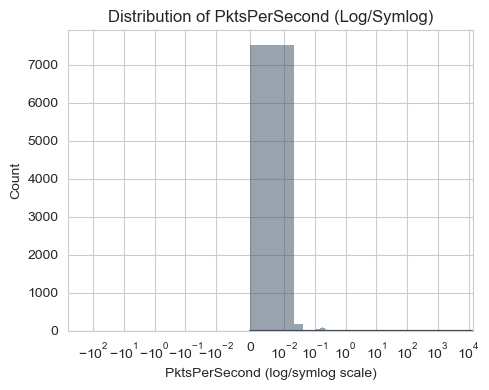


**Plot Name:** Distribution of SrcAddrEntropy

Stats for plotted feature:

| Metric | Value |
|---|---|
| count | 10882.0 |
| mean | 2.898843920681802 |
| std | 0.10173272608708873 |
| min | 2.625814583693911 |
| 25% | 2.8150724101159437 |
| 50% | 2.8150724101159437 |
| 75% | 3.0269868333592873 |
| max | 3.027169118440619 |

data: 2.625814583693911
Applied log scale for this plot

Plot for SrcAddrEntropy saved to plots/S3_src_addr_entropy_dist.png


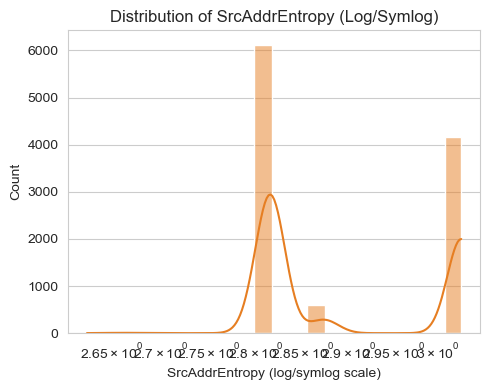


**Plot Name:** Distribution of DstAddrEntropy

Stats for plotted feature:

| Metric | Value |
|---|---|
| count | 10882.0 |
| mean | 2.8619192823547737 |
| std | 0.04248657782943195 |
| min | 2.1180782093497093 |
| 25% | 2.855388542207534 |
| 50% | 2.855388542207534 |
| 75% | 2.855388542207534 |
| max | 3.039148671903071 |

data: 2.1180782093497093
Applied log scale for this plot

Plot for DstAddrEntropy saved to plots/S3_dst_addr_entropy_dist.png


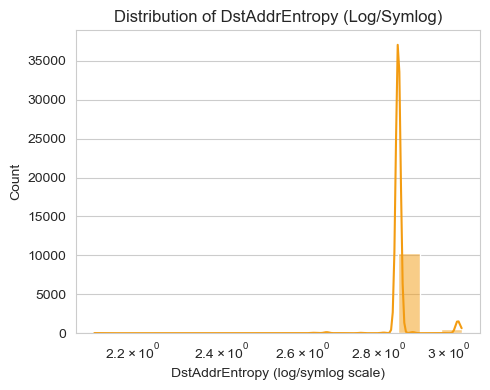

In [21]:
# Section 3 Basic Data Cleaning & Feature Engineering
# Removes background flows, creates derived features like entropy, BytePktRatio, etc., and encodes categorical columns.

log_and_print("\n\nSECTION 3 (Enhanced): BASIC DATA CLEANING & FEATURE ENGINEERING\n", main_logger, level='info')

# 1. Remove rows containing 'Background' from the label
if 'Label' in df.columns:
    df = df[~df['Label'].str.contains('Background', case=False, na=False)]
    df['Botnet'] = df['Label'].apply(lambda x: 1 if 'botnet' in str(x).lower() else 0)
    df.drop(columns=['Label'], inplace=True)
else:
    warning_msg = "No 'Label' column found. Modify label handling as appropriate."
    log_and_print(warning_msg, main_logger, level='warning')

# 2. Drop columns not needed
cols_to_remove = ['sTos', 'dTos', 'StartTime']
for col in cols_to_remove:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

def safe_divide(num, denom):
    return num / denom if denom != 0 else 0

# 3. Derived rate features
df['BytesPerSecond'] = df.apply(lambda row: safe_divide(row['TotBytes'], row['Dur']), axis=1)
df['PktsPerSecond'] = df.apply(lambda row: safe_divide(row['TotPkts'], row['Dur']), axis=1)

# 4. Address entropy features
def address_entropy(addr):
    """
    Computes a simple entropy measure based on the character distribution
    of the string version of an IP address.
    """
    addr_str = str(addr)
    c_count = Counter(addr_str)
    total_chars = len(addr_str)
    if total_chars < 2:
        return 0
    e_value = 0
    for char_count in c_count.values():
        p = char_count / total_chars
        e_value -= p * math.log2(p)
    return e_value

df['SrcAddrEntropy'] = df['SrcAddr'].apply(address_entropy)
df['DstAddrEntropy'] = df['DstAddr'].apply(address_entropy)

# 5. Port range bucketing
def get_port_range(x):
    try:
        port = int(x)
    except (ValueError, TypeError):
        return 'Unknown'
    if 0 <= port <= 1023:
        return 'WellKnown'
    elif 1024 <= port <= 49151:
        return 'Registered'
    elif 49152 <= port <= 65535:
        return 'Ephemeral'
    else:
        return 'Unknown'

if 'Sport' in df.columns:
    df['SportRange'] = df['Sport'].apply(get_port_range)
    df.drop(columns=['Sport'], inplace=True)

if 'Dport' in df.columns:
    df['DportRange'] = df['Dport'].apply(get_port_range)
    df.drop(columns=['Dport'], inplace=True)

# 6. Session Duration Buckets
import numpy as np

if 'Dur' in df.columns:
    bins = [0, 1, 10, 60, np.inf]
    labels = ['very_short', 'short', 'medium', 'long']
    df['DurCategory'] = pd.cut(df['Dur'], bins=bins, labels=labels, include_lowest=True)
    durcat_counts = df['DurCategory'].value_counts().to_dict()
    log_and_print(f"Created DurCategory feature. Distribution: {durcat_counts}", main_logger, level='info')
else:
    log_and_print("WARNING: 'Dur' column not found; skipping DurCategory feature.", main_logger, level='warning')

# 7. NEW FEATURE 2: Byte-to-Packet Ratio
df['BytePktRatio'] = df.apply(lambda row: safe_divide(row['TotBytes'], row['TotPkts']), axis=1)
bpr_stats = df['BytePktRatio'].describe().to_dict()
log_and_print(f"Created BytePktRatio feature. Basic stats: {bpr_stats}", main_logger, level='info')

# Rebuild the main features list
main_features = [
    'Dur', 'Proto', 'Dir', 'State',
    'SrcAddr', 'DstAddr',
    'SportRange', 'DportRange',
    'TotPkts', 'TotBytes', 'SrcBytes',
    'BytesPerSecond', 'PktsPerSecond',
    'BytePktRatio',
    'SrcAddrEntropy', 'DstAddrEntropy',
    'DurCategory',
    'Botnet'
]
df = df[[col for col in main_features if col in df.columns]]

# Separate X, y
if 'Botnet' in df.columns:
    y = df['Botnet']
    X = df.drop('Botnet', axis=1)
    shape_msg = f"Enhanced Feature matrix shape: {X.shape}, Target vector shape: {y.shape}"
    log_and_print(shape_msg, main_logger, level='info')
else:
    error_msg = "No 'Botnet' column identified for classification. Exiting."
    log_and_print(error_msg, main_logger, level='error')
    raise ValueError(error_msg)

# Remove IP columns if not desired
for ip_col in ['SrcAddr', 'DstAddr']:
    if ip_col in X.columns:
        X.drop(columns=[ip_col], inplace=True)

# Convert remaining categorical columns to numeric
categorical_cols = [
    'Proto', 'Dir', 'State',
    'SportRange', 'DportRange',
    'DurCategory'
]
for cat_col in categorical_cols:
    if cat_col in X.columns and X[cat_col].dtype == 'object':
        X[cat_col] = X[cat_col].astype('category').cat.codes

# Log a quick preview
log_and_print("Showing the first few rows of the enhanced DataFrame:", main_logger, level='info')
df_head_markdown = df.head().to_markdown()
log_and_print(f"\n\n{df_head_markdown}\n", main_logger, level='info')

buf = io.StringIO()
df.info(buf=buf)
info_str = buf.getvalue()
log_and_print(f"\n\n{info_str}\n", main_logger, level='info')

# Helper to apply log or symlog scale automatically
def log_stats_as_markdown(feature_name, stats_dict, data_min):
    """
    Logs numeric summary stats in Markdown table form,
    and logs the min value plus scale usage (log or symlog).
    """
    log_and_print(f"\n**Plot Name:** Distribution of {feature_name}\n", main_logger, level='info')
    stats_table = "Stats for plotted feature:\n\n| Metric | Value |\n|---|---|\n"
    for k, v in stats_dict.items():
        stats_table += f"| {k} | {v} |\n"
    log_and_print(stats_table, main_logger, level='info')
    log_and_print(f"data: {data_min}", main_logger, level='info')

def apply_log_scale_with_stats(ax, data_series, axis='x', feature_name='Feature'):
    """
    Chooses a log scale if data_min>0 or a symlog scale otherwise,
    and logs relevant stats to the main_logger.
    """
    stats_dict = data_series.describe().to_dict()
    data_min = data_series.min()

    # Log stats
    log_stats_as_markdown(feature_name, stats_dict, data_min)

    # Decide log vs symlog
    if data_min <= 0:
        scale_used = "symlog"
        if axis == 'x':
            ax.set_xscale('symlog', linthresh=1e-2)
        else:
            ax.set_yscale('symlog', linthresh=1e-2)
    else:
        scale_used = "log"
        if axis == 'x':
            ax.set_xscale('log')
        else:
            ax.set_yscale('log')

    log_and_print(f"Applied {scale_used} scale for this plot\n", main_logger, level='info')

# VISUALIZATIONS for new features
# 1) DurCategory distribution
if 'DurCategory' in df.columns:
    plt.figure(figsize=(5, 4))
    durcat_order = df['DurCategory'].value_counts().index
    ax = sns.countplot(data=df, x='DurCategory', order=durcat_order, color="#9b59b6")

    log_and_print("\n**Plot Name:** Distribution of DurCategory\n", main_logger, level='info')
    durcat_series = df['DurCategory'].value_counts()
    cat_table = "Stats for plotted feature (DurCategory counts):\n\n| Category | Count |\n|---|---|\n"
    for cat_val, cat_cnt in durcat_series.items():
        cat_table += f"| {cat_val} | {cat_cnt} |\n"
    log_and_print(cat_table, main_logger, level='info')

    ax.set_yscale('log')
    plt.title("Distribution of DurCategory (Log-Scaled Counts)")
    plt.xlabel("DurCategory")
    plt.ylabel("Count (log scale)")
    durcat_plot_file = os.path.join(PLOTS_FOLDER, "S3_durcategory_distribution.png")
    plt.tight_layout()
    plt.savefig(durcat_plot_file, dpi=300)
    log_and_print(f"DurCategory distribution plot saved to {durcat_plot_file}", main_logger, level='info')
    plt.show()

# 2) BytePktRatio box plot
if 'BytePktRatio' in df.columns:
    plt.figure(figsize=(5, 4))
    ax = sns.boxplot(y=df['BytePktRatio'], color="#f1c40f")
    apply_log_scale_with_stats(ax, df['BytePktRatio'], axis='y', feature_name='BytePktRatio')

    plt.title("Box Plot of BytePktRatio (Log/Symlog)")
    plt.ylabel("BytePktRatio (log/symlog scale)")
    bpr_plot_file = os.path.join(PLOTS_FOLDER, "S3_bytepktratio_boxplot.png")
    plt.tight_layout()
    plt.savefig(bpr_plot_file, dpi=300)
    log_and_print(f"BytePktRatio box plot saved to {bpr_plot_file}", main_logger, level='info')
    plt.show()

# 3) BytesPerSecond distribution
if 'BytesPerSecond' in df.columns:
    plt.figure(figsize=(5, 4))
    ax = sns.histplot(x=df['BytesPerSecond'], color="#2ecc71", kde=True)
    apply_log_scale_with_stats(ax, df['BytesPerSecond'], axis='x', feature_name='BytesPerSecond')

    plt.title("Distribution of BytesPerSecond (Log/Symlog)")
    plt.xlabel("BytesPerSecond (log/symlog scale)")
    bps_plot_file = os.path.join(PLOTS_FOLDER, "S3_bytes_per_second_dist.png")
    plt.tight_layout()
    plt.savefig(bps_plot_file, dpi=300)
    log_and_print(f"Plot for BytesPerSecond saved to {bps_plot_file}", main_logger, level='info')
    plt.show()

# 4) PktsPerSecond distribution
if 'PktsPerSecond' in df.columns:
    plt.figure(figsize=(5, 4))
    ax = sns.histplot(x=df['PktsPerSecond'], color="#34495e", kde=True)
    apply_log_scale_with_stats(ax, df['PktsPerSecond'], axis='x', feature_name='PktsPerSecond')

    plt.title("Distribution of PktsPerSecond (Log/Symlog)")
    plt.xlabel("PktsPerSecond (log/symlog scale)")
    pktps_plot_file = os.path.join(PLOTS_FOLDER, "S3_pkts_per_second_dist.png")
    plt.tight_layout()
    plt.savefig(pktps_plot_file, dpi=300)
    log_and_print(f"Plot for PktsPerSecond saved to {pktps_plot_file}", main_logger, level='info')
    plt.show()

# 5) SrcAddrEntropy distribution
if 'SrcAddrEntropy' in df.columns:
    plt.figure(figsize=(5, 4))
    ax = sns.histplot(x=df['SrcAddrEntropy'], color="#e67e22", kde=True)
    apply_log_scale_with_stats(ax, df['SrcAddrEntropy'], axis='x', feature_name='SrcAddrEntropy')

    plt.title("Distribution of SrcAddrEntropy (Log/Symlog)")
    plt.xlabel("SrcAddrEntropy (log/symlog scale)")
    src_ent_plot_file = os.path.join(PLOTS_FOLDER, "S3_src_addr_entropy_dist.png")
    plt.tight_layout()
    plt.savefig(src_ent_plot_file, dpi=300)
    log_and_print(f"Plot for SrcAddrEntropy saved to {src_ent_plot_file}", main_logger, level='info')
    plt.show()

# 6) DstAddrEntropy distribution
if 'DstAddrEntropy' in df.columns:
    plt.figure(figsize=(5, 4))
    ax = sns.histplot(x=df['DstAddrEntropy'], color="#f39c12", kde=True)
    apply_log_scale_with_stats(ax, df['DstAddrEntropy'], axis='x', feature_name='DstAddrEntropy')

    plt.title("Distribution of DstAddrEntropy (Log/Symlog)")
    plt.xlabel("DstAddrEntropy (log/symlog scale)")
    dst_ent_plot_file = os.path.join(PLOTS_FOLDER, "S3_dst_addr_entropy_dist.png")
    plt.tight_layout()
    plt.savefig(dst_ent_plot_file, dpi=300)
    log_and_print(f"Plot for DstAddrEntropy saved to {dst_ent_plot_file}", main_logger, level='info')
    plt.show()

# This section removed background flows, created derived fields (entropy, ratio, rates), performed data type conversions, and plotted some distributions of these new features.

## Section 4 Visualizations



SECTION 4: VISUALIZATIONS

Creating basic visualizations...
S4 - Bar/Pie chart figure saved to plots/S4_botnet_distribution.png


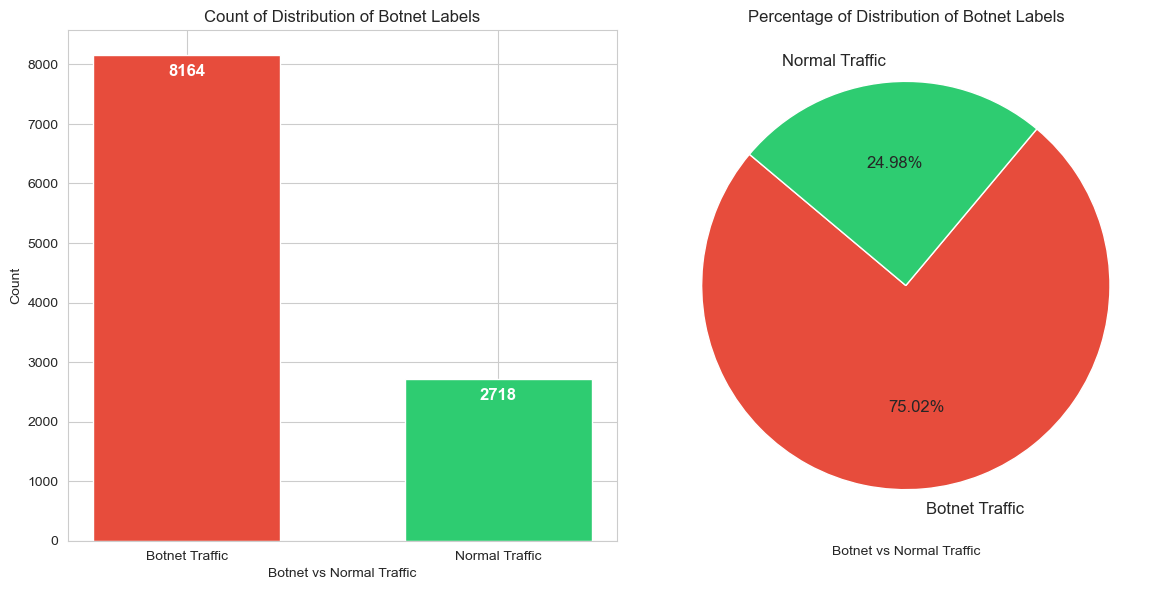


**Botnet vs Normal Distribution**

| Key | Value |
|---|---|
| 1 | 8164 |
| 0 | 2718 |

S4 - Hierarchically clustered correlogram saved to plots/S4_correlation_clustered.png


<Figure size 640x480 with 0 Axes>

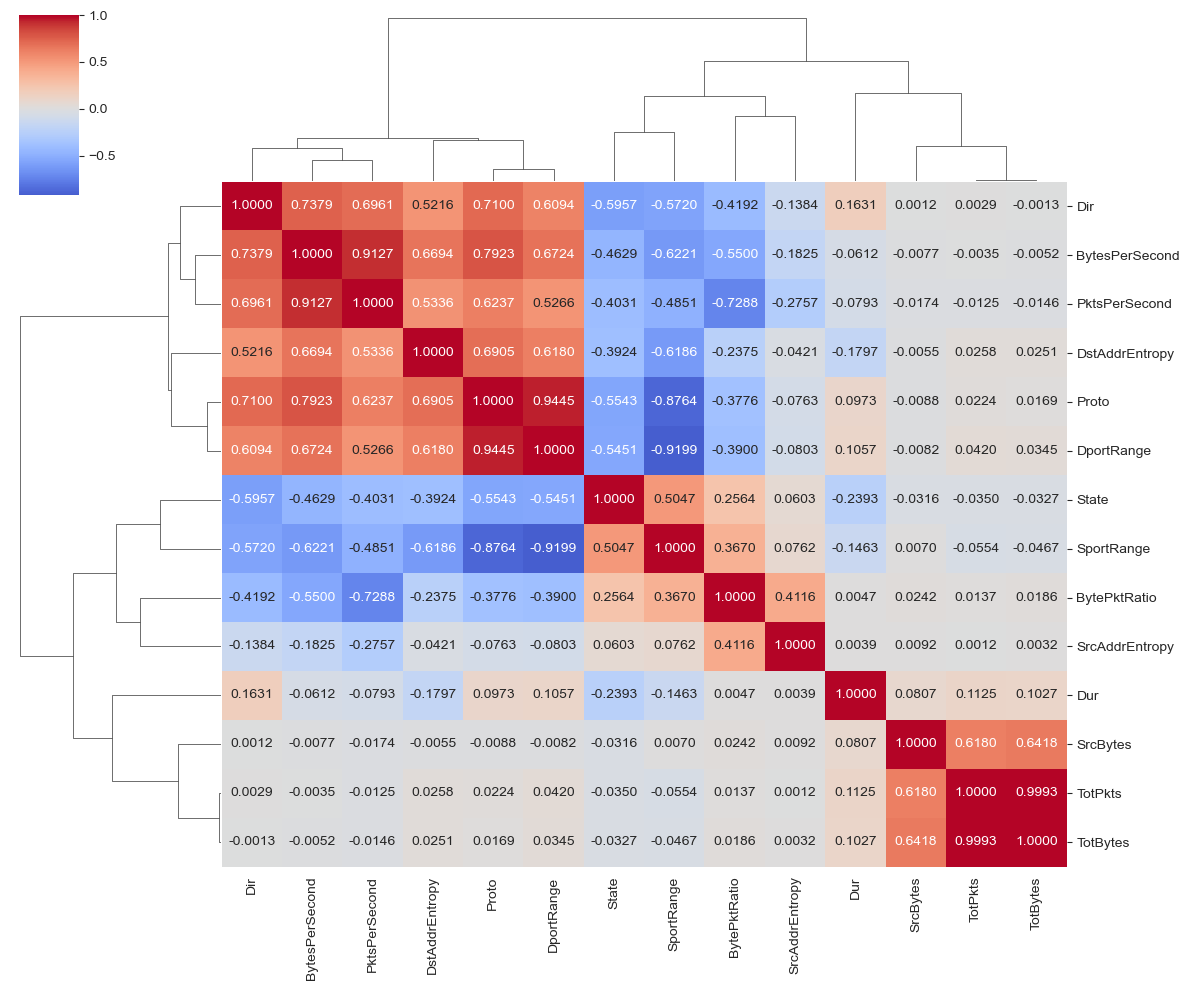

Creating additional distribution plots for numeric & categorical features...
S4 - Count plot saved to plots/S4_countplot_sortrange_botnet.png


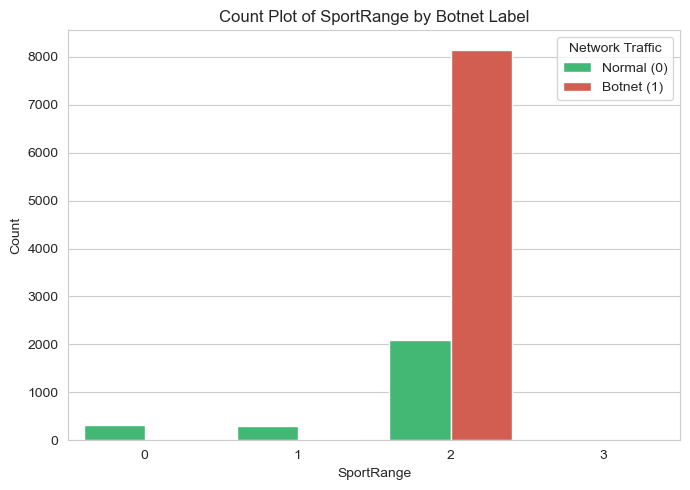


**S4 - SportRange Distribution Counts**

| Key | Value |
|---|---|
| (0, 0) | 315 |
| (1, 0) | 309 |
| (1, 1) | 18 |
| (2, 0) | 2089 |
| (2, 1) | 8143 |
| (3, 0) | 5 |
| (3, 1) | 3 |

S4 - Box plot saved to plots/S4_boxplot_pktspersec_botnet.png


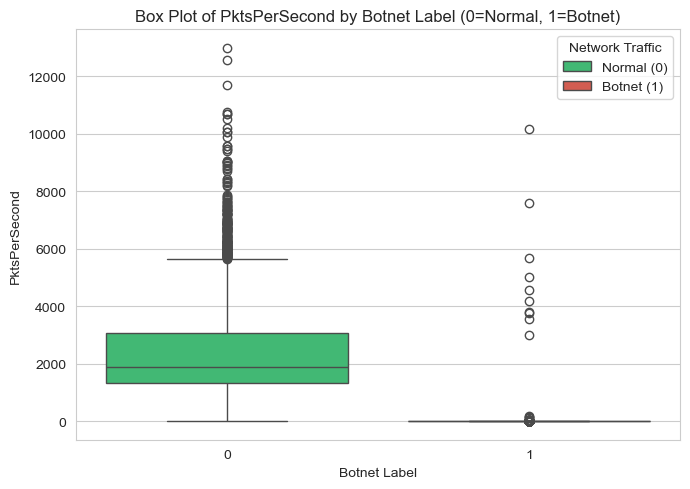


**S4 - PktsPerSecond Stats**

| Key | Value |
|---|---|
| count | 10882.0 |
| mean | 601.4648290374602 |
| std | 1396.1123327844919 |
| min | 0.0 |
| 25% | 0.0 |
| 50% | 0.0 |
| 75% | 0.23277560736508965 |
| max | 12987.012987012988 |

S4 - Strip plot saved to plots/S4_stripplot_bytespersec_botnet.png


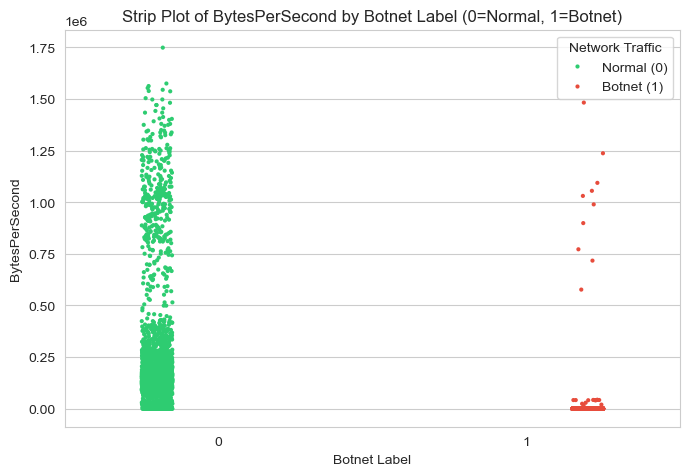


**S4 - BytesPerSecond Stats**

| Key | Value |
|---|---|
| count | 10882.0 |
| mean | 65707.63308488764 |
| std | 195364.19446829928 |
| min | 0.0 |
| 25% | 0.0 |
| 50% | 0.0 |
| 75% | 243.2164971812862 |
| max | 1748538.0116959063 |

Creating recommended additional visualizations for numeric vs. Botnet...
S4 - Pair plot with hue=Botnet saved to plots/S4_pairplot_numeric_botnet.png


<Figure size 640x480 with 0 Axes>

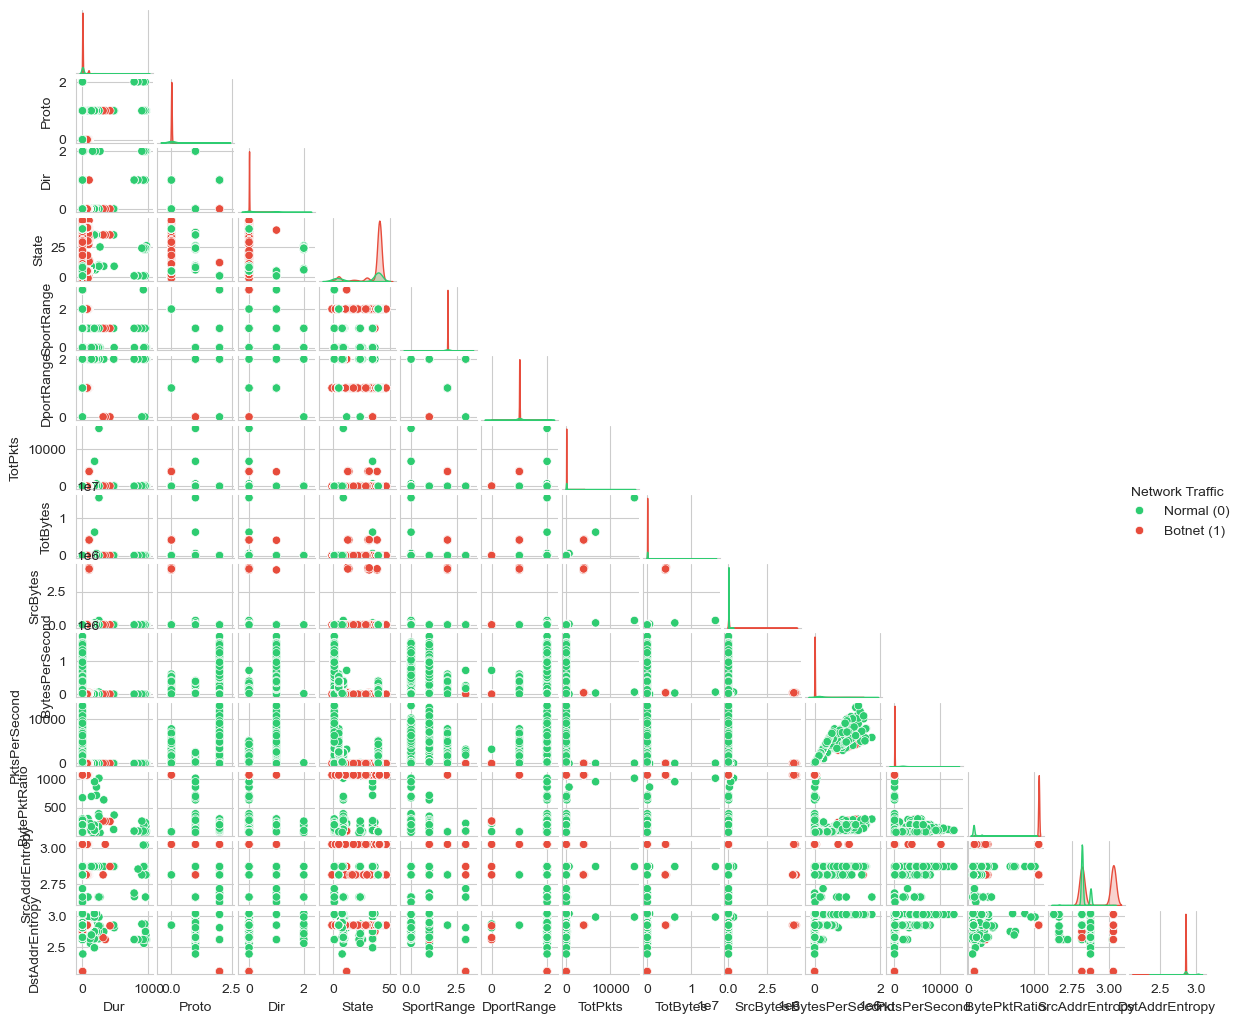

S4 - Violin plot for BytesPerSecond saved to plots/S4_violinplot_bytespersec_botnet.png


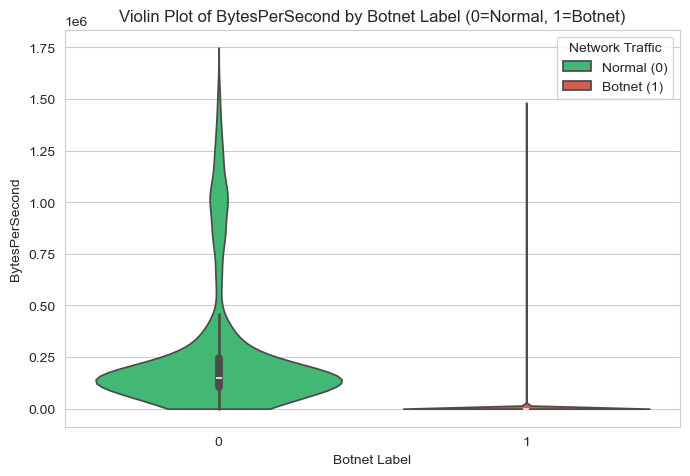

SECTION 4 visualizations complete.



In [22]:
# Section 4 Visualizations
# Additional plots for Botnet vs Normal distribution, correlation, pair plots, etc.)

log_and_print("\n\nSECTION 4: VISUALIZATIONS\n", main_logger, level='info')
log_and_print("Creating basic visualizations...", main_logger, level='info')

os.makedirs(PLOTS_FOLDER, exist_ok=True)

def dict_to_markdown_table(title, d):
    md = f"\n**{title}**\n\n| Key | Value |\n|---|---|\n"
    for k, v in d.items():
        md += f"| {k} | {v} |\n"
    return md

# 1) Bar & Pie Chart of Botnet vs Normal
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

counts = y.value_counts()
labels_map = {0: "Normal Traffic", 1: "Botnet Traffic"}
plot_labels = [labels_map.get(idx, str(idx)) for idx in counts.index]
plot_values = counts.values

bar_colors = []
for lbl in plot_labels:
    if "Normal" in lbl:
        bar_colors.append(COLOR_NORMAL)
    elif "Botnet" in lbl:
        bar_colors.append(COLOR_BOTNET)
    else:
        bar_colors.append("#999999")

axes[0].bar(plot_labels, plot_values, color=bar_colors, width=0.6)

max_val = max(plot_values)
offset = max_val * 0.05
for i, v in enumerate(plot_values):
    axes[0].text(
        i,
        v - offset,
        str(v),
        ha='center',
        va='bottom',
        color='white',
        fontweight='bold',
        fontsize=12
    )

axes[0].set_title("Count of Distribution of Botnet Labels")
axes[0].set_xlabel("Botnet vs Normal Traffic")
axes[0].set_ylabel("Count")

axes[1].pie(
    plot_values,
    labels=plot_labels,
    colors=bar_colors,
    autopct='%1.2f%%',
    startangle=140,
    textprops={'fontsize': 12}
)
axes[1].set_title("Percentage of Distribution of Botnet Labels")
axes[1].set_xlabel("Botnet vs Normal Traffic")

bar_pie_filename = os.path.join(PLOTS_FOLDER, "S4_botnet_distribution.png")
plt.tight_layout()
plt.savefig(bar_pie_filename, dpi=300)
log_and_print(f"S4 - Bar/Pie chart figure saved to {bar_pie_filename}", main_logger, level='info')
plt.show()

counts_md = dict_to_markdown_table("Botnet vs Normal Distribution", counts.to_dict())
log_and_print(counts_md, main_logger, level='info')

# 2) Hierarchically clustered correlation for numeric features
X_numeric = X.select_dtypes(include=[np.number])
if (X_numeric.shape[0] > 1) and (X_numeric.shape[1] > 1):
    correlation_matrix = X_numeric.corr()

    plt.figure()
    cg = sns.clustermap(
        correlation_matrix,
        method='average',
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt=".4f",
        figsize=(12, 10)
    )
    cluster_filename = os.path.join(PLOTS_FOLDER, "S4_correlation_clustered.png")
    plt.savefig(cluster_filename, dpi=300)
    log_and_print(f"S4 - Hierarchically clustered correlogram saved to {cluster_filename}", main_logger, level='info')
    plt.show()
else:
    msg_warn = (
        f"Skipping correlation matrix. X_numeric has shape {X_numeric.shape}, needs ≥2 rows & 2 columns."
    )
    log_and_print("WARNING: " + msg_warn, main_logger, level='warning')

log_and_print("Creating additional distribution plots for numeric & categorical features...", main_logger, level='info')

# 3A) SportRange vs Botnet
if 'SportRange' in X.columns:
    plt.figure(figsize=(7, 5))
    df_count = pd.DataFrame({'SportRange': X['SportRange'], 'Botnet': y})
    ax = sns.countplot(
        data=df_count,
        x='SportRange',
        hue='Botnet',
        palette=[COLOR_NORMAL, COLOR_BOTNET]
    )
    plt.title("Count Plot of SportRange by Botnet Label")
    plt.xlabel("SportRange")
    plt.ylabel("Count")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Normal (0)", "Botnet (1)"], title="Network Traffic")

    countplot_filename = os.path.join(PLOTS_FOLDER, "S4_countplot_sortrange_botnet.png")
    plt.tight_layout()
    plt.savefig(countplot_filename, dpi=300)
    log_and_print(f"S4 - Count plot saved to {countplot_filename}", main_logger, level='info')
    plt.show()

    sr_counts = df_count.groupby(["SportRange", "Botnet"]).size().to_dict()
    sr_md = dict_to_markdown_table("S4 - SportRange Distribution Counts", sr_counts)
    log_and_print(sr_md, main_logger, level='info')

# 3B) Boxplot: PktsPerSecond by Botnet
df_pkts = pd.DataFrame({'Botnet': y, 'PktsPerSecond': X['PktsPerSecond']})
plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    x='Botnet',
    y='PktsPerSecond',
    data=df_pkts,
    hue='Botnet',
    palette=[COLOR_NORMAL, COLOR_BOTNET]
)
plt.title("Box Plot of PktsPerSecond by Botnet Label (0=Normal, 1=Botnet)")
plt.xlabel("Botnet Label")
plt.ylabel("PktsPerSecond")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Normal (0)", "Botnet (1)"], title="Network Traffic")

boxplot_filename = os.path.join(PLOTS_FOLDER, "S4_boxplot_pktspersec_botnet.png")
plt.tight_layout()
plt.savefig(boxplot_filename, dpi=300)
log_and_print(f"S4 - Box plot saved to {boxplot_filename}", main_logger, level='info')
plt.show()

pkts_stats = df_pkts['PktsPerSecond'].describe().to_dict()
pkts_md = dict_to_markdown_table("S4 - PktsPerSecond Stats", pkts_stats)
log_and_print(pkts_md, main_logger, level='info')

# 3C) Strip Plot: BytesPerSecond vs Botnet
df_bps = pd.DataFrame({'BytesPerSecond': X['BytesPerSecond'], 'Botnet': y})
plt.figure(figsize=(7, 5))
ax = sns.stripplot(
    x='Botnet',
    y='BytesPerSecond',
    data=df_bps,
    hue='Botnet',
    size=3,
    jitter=True,
    palette=[COLOR_NORMAL, COLOR_BOTNET],
    dodge=True
)
plt.title("Strip Plot of BytesPerSecond by Botnet Label (0=Normal, 1=Botnet)")
plt.xlabel("Botnet Label")
plt.ylabel("BytesPerSecond")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Normal (0)", "Botnet (1)"], title="Network Traffic")

stripplot_filename = os.path.join(PLOTS_FOLDER, "S4_stripplot_bytespersec_botnet.png")
plt.tight_layout()
plt.savefig(stripplot_filename, dpi=300)
log_and_print(f"S4 - Strip plot saved to {stripplot_filename}", main_logger, level='info')
plt.show()

bps_stats = df_bps['BytesPerSecond'].describe().to_dict()
bps_md = dict_to_markdown_table("S4 - BytesPerSecond Stats", bps_stats)
log_and_print(bps_md, main_logger, level='info')

# 4) Pair Plot of numeric features, hue='Botnet'
log_and_print("Creating recommended additional visualizations for numeric vs. Botnet...", main_logger, level='info')
plot_df = X_numeric.copy()
plot_df['Botnet'] = y

plt.figure()
pair_g = sns.pairplot(
    data=plot_df,
    hue='Botnet',
    diag_kind='kde',
    palette=[COLOR_NORMAL, COLOR_BOTNET],
    corner=True
)
pair_g.fig.set_size_inches(12, 10)
pair_g._legend.set_title("Network Traffic")
new_labels = ["Normal (0)", "Botnet (1)"]
for t, l in zip(pair_g._legend.texts, new_labels):
    t.set_text(l)

pairplot_filename = os.path.join(PLOTS_FOLDER, "S4_pairplot_numeric_botnet.png")
pair_g.savefig(pairplot_filename, dpi=300)
log_and_print(f"S4 - Pair plot with hue=Botnet saved to {pairplot_filename}", main_logger, level='info')
plt.show()

# 4B) Violin Plot for BytesPerSecond vs. Botnet
if 'BytesPerSecond' in X_numeric.columns:
    plt.figure(figsize=(7, 5))
    ax = sns.violinplot(
        x='Botnet',
        y='BytesPerSecond',
        data=plot_df,
        hue='Botnet',
        palette=[COLOR_NORMAL, COLOR_BOTNET],
        cut=0
    )
    plt.title("Violin Plot of BytesPerSecond by Botnet Label (0=Normal, 1=Botnet)")
    plt.xlabel("Botnet Label")
    plt.ylabel("BytesPerSecond")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Normal (0)", "Botnet (1)"], title="Network Traffic")

    violin_filename = os.path.join(PLOTS_FOLDER, "S4_violinplot_bytespersec_botnet.png")
    plt.tight_layout()
    plt.savefig(violin_filename, dpi=300)
    log_and_print(f"S4 - Violin plot for BytesPerSecond saved to {violin_filename}", main_logger, level='info')
    plt.show()

log_and_print("SECTION 4 visualizations complete.\n", main_logger, level='info')

# This section created additional plots to visualize Botnet vs Normal distributions, correlations, pair plots, and more advanced visual analysis of numeric features.


## Section 5 Train-Test Split and Multi-Model Pipeline



SECTION 5: TRAIN-TEST SPLIT AND MULTI-MODEL PIPELINE

Splitting dataset into train and test sets...
Train set shape: (8705, 15), Test set shape: (2177, 15)
Ensuring all features are numeric by converting categorical columns to codes...

------------------------------------------------------------
STARTING MODEL: RandomForest (GridSearchCV)
------------------------------------------------------------

Fitting RandomForest model with GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
RandomForest -> Training time: 2.70 seconds

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      1.00      1.00      2177
weighted avg       1.00      1.00      1.00      2177

RandomForest -> Best Params: {'clf__max_depth': 10, 'clf__min_samples_lea

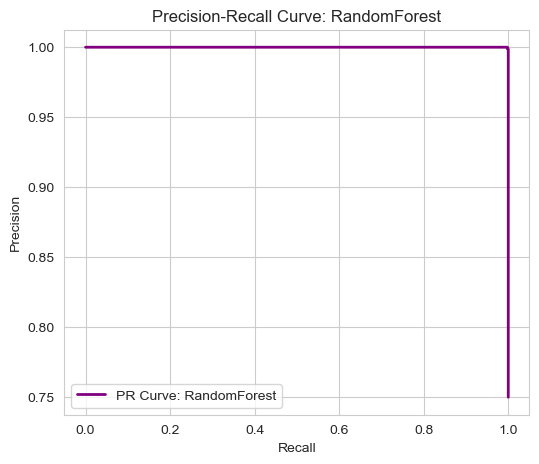

S5 - Gains chart saved to plots/S5_gains_RandomForest.png


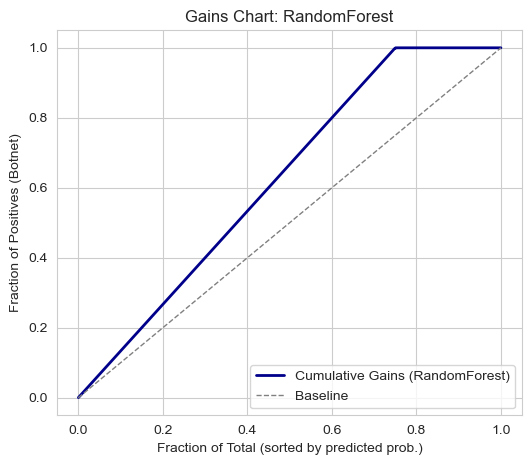

S5 - Calibration curve saved to plots/S5_calibration_RandomForest.png


<Figure size 600x500 with 0 Axes>

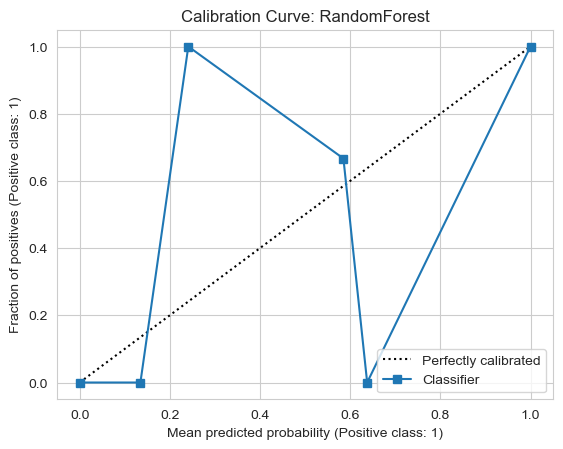

S5 - ROC curve saved to plots/S5_roc_RandomForest.png


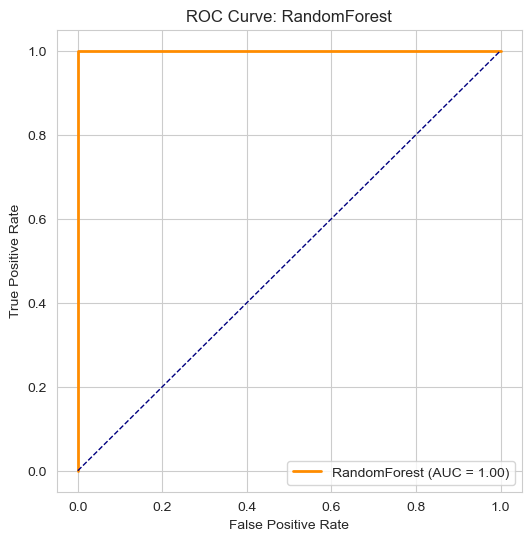

S5 - Confusion matrix saved to plots/S5_confusion_matrix_RandomForest.png


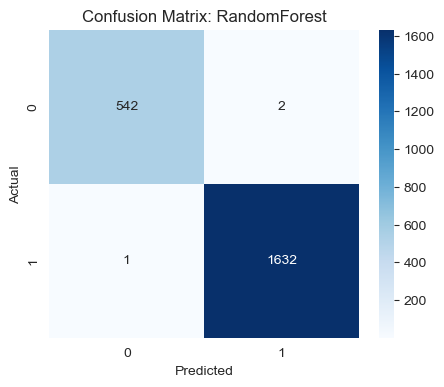

S5 - Top 10 features bar chart saved to plots/S5_top10_features_RandomForest.png


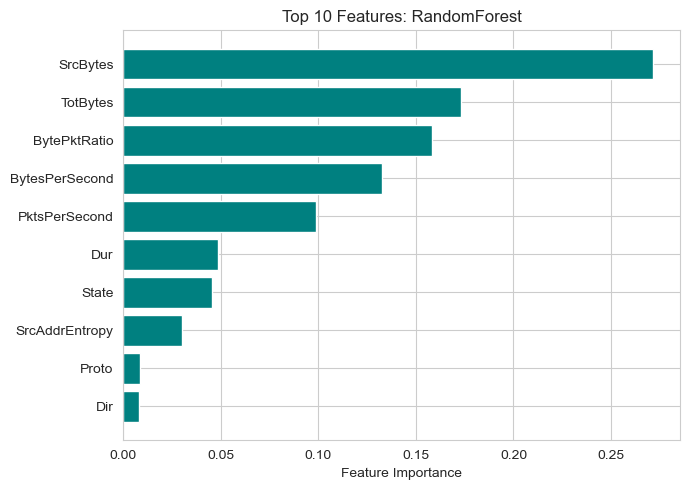



------------------------------------------------------------
FINISHED MODEL: RandomForest
------------------------------------------------------------

Starting GridSearch for DecisionTree...

------------------------------------------------------------
STARTING MODEL: DecisionTree (GridSearchCV)
------------------------------------------------------------

Fitting DecisionTree model with GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
DecisionTree -> Training time: 0.09 seconds

Classification Report for DecisionTree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      1.00      1.00      2177
weighted avg       1.00      1.00      1.00      2177

DecisionTree -> Best Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Decision

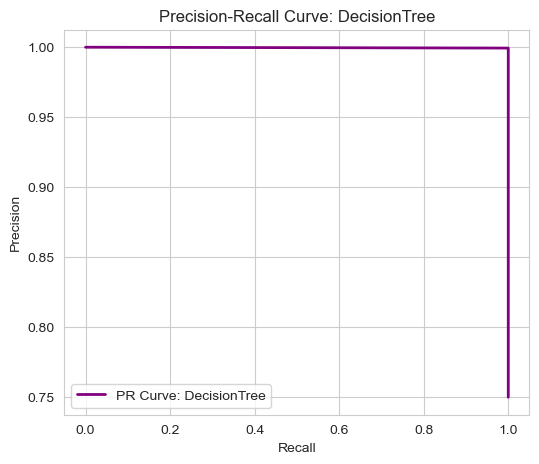

S5 - Gains chart saved to plots/S5_gains_DecisionTree.png


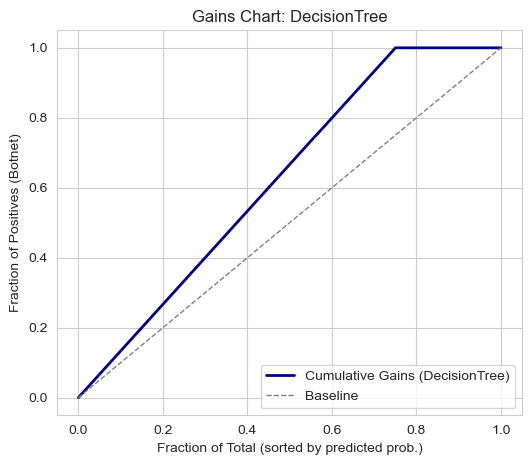

S5 - Calibration curve saved to plots/S5_calibration_DecisionTree.png


<Figure size 600x500 with 0 Axes>

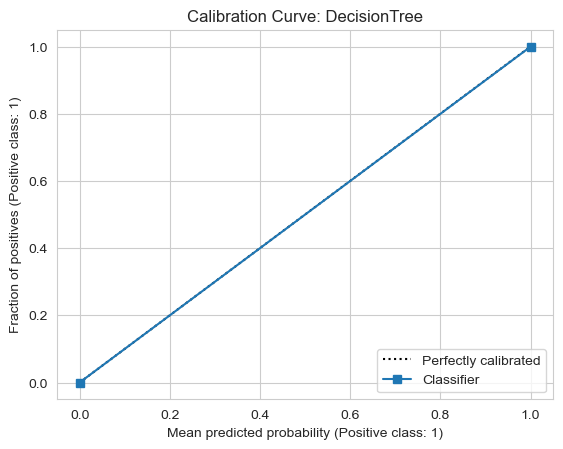

S5 - ROC curve saved to plots/S5_roc_DecisionTree.png


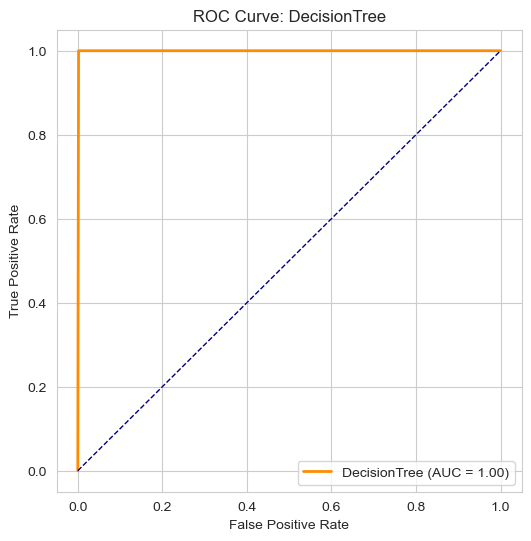

S5 - Confusion matrix saved to plots/S5_confusion_matrix_DecisionTree.png


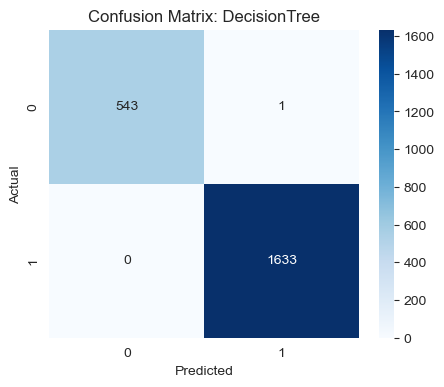

S5 - Top 10 features bar chart saved to plots/S5_top10_features_DecisionTree.png


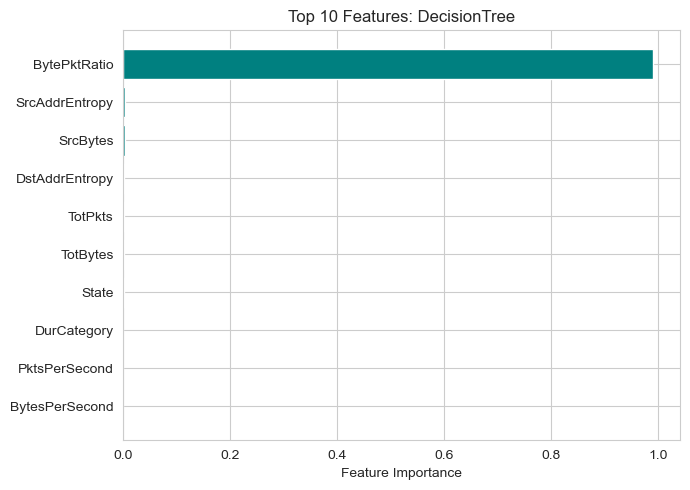



------------------------------------------------------------
FINISHED MODEL: DecisionTree
------------------------------------------------------------

Starting GridSearch for NaiveBayes...

------------------------------------------------------------
STARTING MODEL: NaiveBayes (GridSearchCV)
------------------------------------------------------------

Fitting NaiveBayes model with GridSearchCV...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
NaiveBayes -> Training time: 0.04 seconds

Classification Report for NaiveBayes:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      1.00      1.00      2177
weighted avg       1.00      1.00      1.00      2177

NaiveBayes -> Best Params: {'clf__var_smoothing': 1e-09}
NaiveBayes -> Best CV Score (F1): 0.9985
NaiveBayes -> Test Accuracy: 0

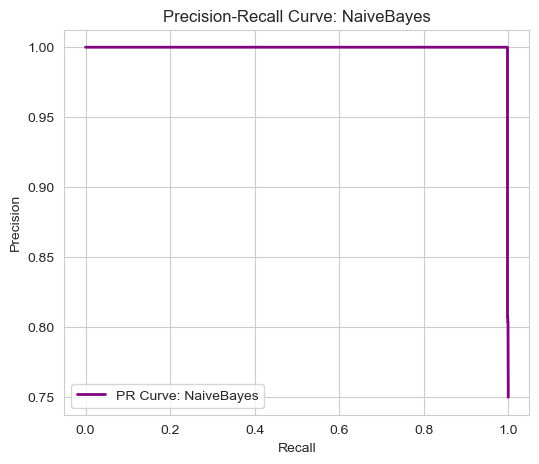

S5 - Gains chart saved to plots/S5_gains_NaiveBayes.png


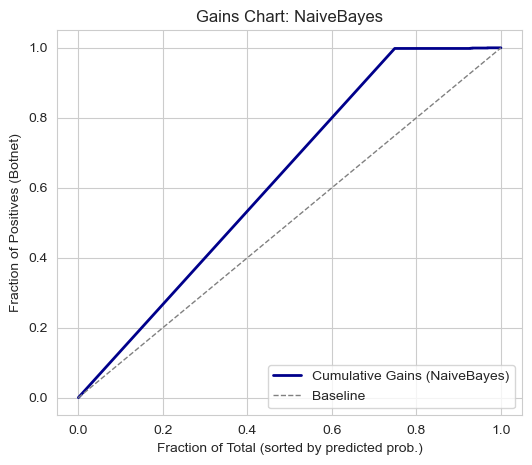

S5 - Calibration curve saved to plots/S5_calibration_NaiveBayes.png


<Figure size 600x500 with 0 Axes>

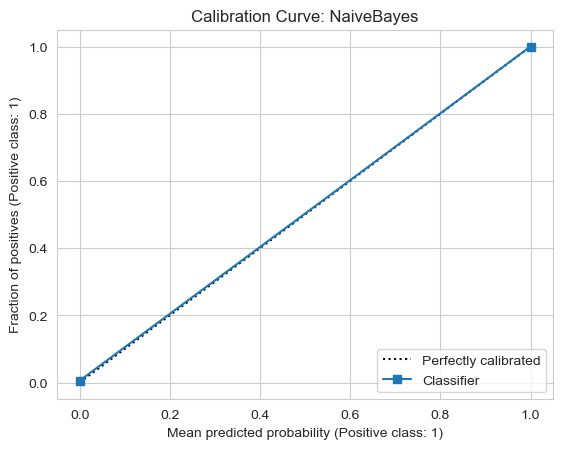

S5 - ROC curve saved to plots/S5_roc_NaiveBayes.png


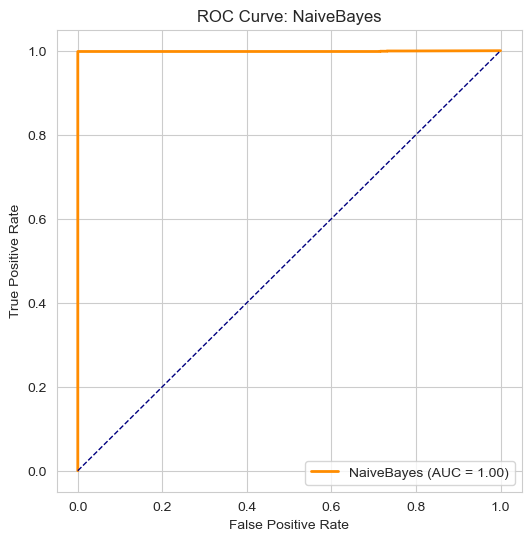

S5 - Confusion matrix saved to plots/S5_confusion_matrix_NaiveBayes.png


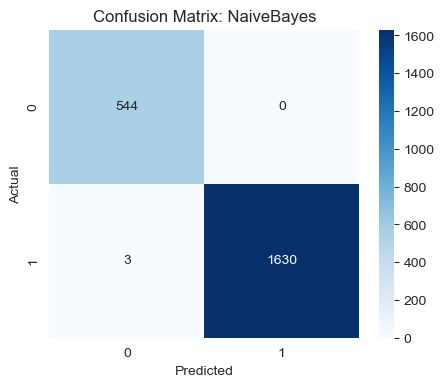



------------------------------------------------------------
FINISHED MODEL: NaiveBayes
------------------------------------------------------------

Starting GridSearch for KNN...

------------------------------------------------------------
STARTING MODEL: KNN (GridSearchCV)
------------------------------------------------------------

Fitting KNN model with GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
KNN -> Training time: 0.22 seconds

Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      1.00      1.00      2177
weighted avg       1.00      1.00      1.00      2177

KNN -> Best Params: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
KNN -> Best CV Score (F1): 0.9989
KNN -> Test Accuracy: 0.9991
KNN -> Test Precision: 1.0000


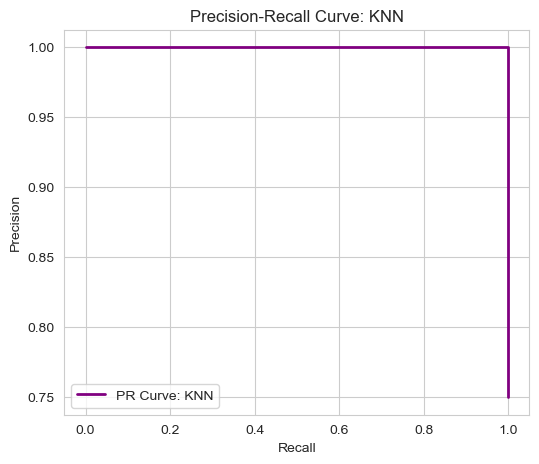

S5 - Gains chart saved to plots/S5_gains_KNN.png


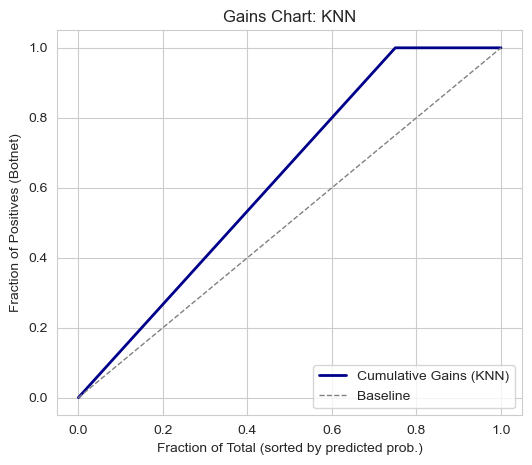

S5 - Calibration curve saved to plots/S5_calibration_KNN.png


<Figure size 600x500 with 0 Axes>

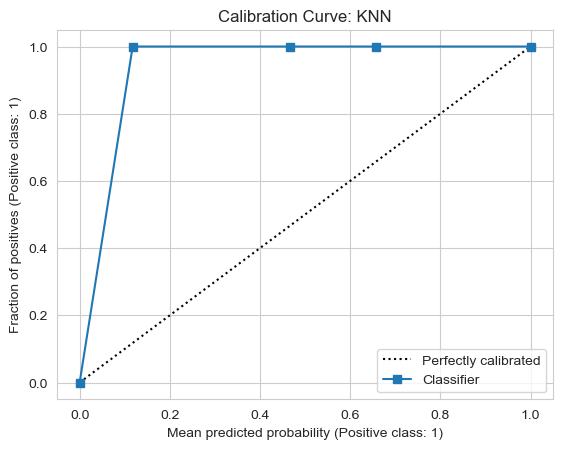

S5 - ROC curve saved to plots/S5_roc_KNN.png


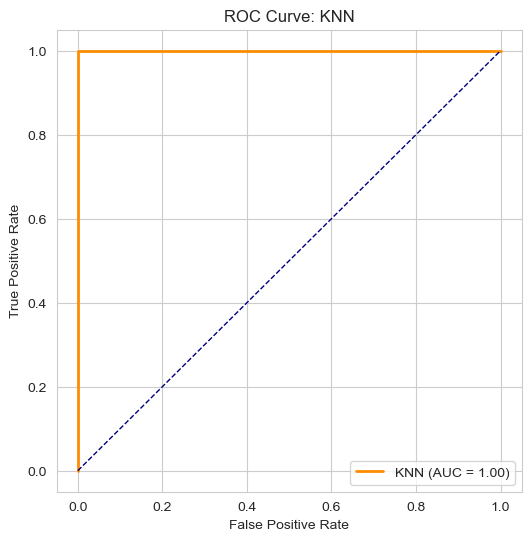

S5 - Confusion matrix saved to plots/S5_confusion_matrix_KNN.png


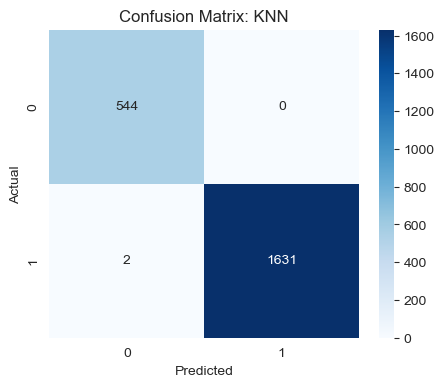



------------------------------------------------------------
FINISHED MODEL: KNN
------------------------------------------------------------

Starting GridSearch for SVM...

------------------------------------------------------------
STARTING MODEL: SVM (GridSearchCV)
------------------------------------------------------------

Fitting SVM model with GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVM -> Training time: 0.93 seconds

Classification Report for SVM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      1.00      1.00      2177
weighted avg       1.00      1.00      1.00      2177

SVM -> Best Params: {'clf__C': 10.0, 'clf__kernel': 'linear'}
SVM -> Best CV Score (F1): 0.9991
SVM -> Test Accuracy: 0.9991
SVM -> Test Precision: 1.0000
SVM -> Test Recal

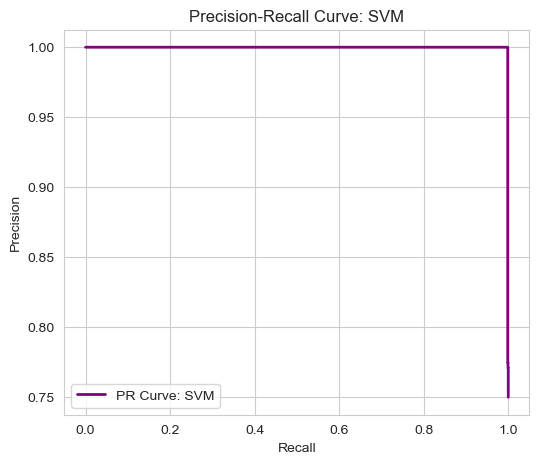

S5 - Gains chart saved to plots/S5_gains_SVM.png


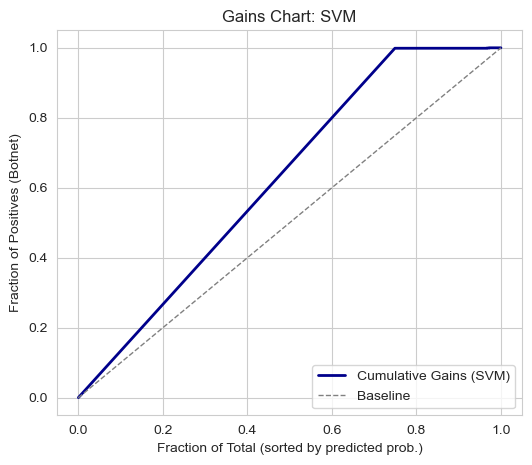

S5 - Calibration curve saved to plots/S5_calibration_SVM.png


<Figure size 600x500 with 0 Axes>

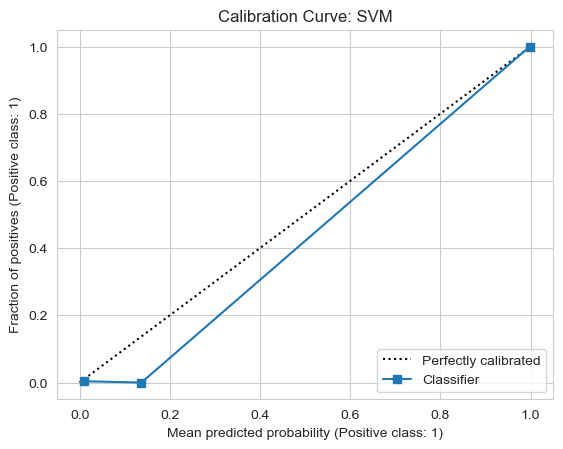

S5 - ROC curve saved to plots/S5_roc_SVM.png


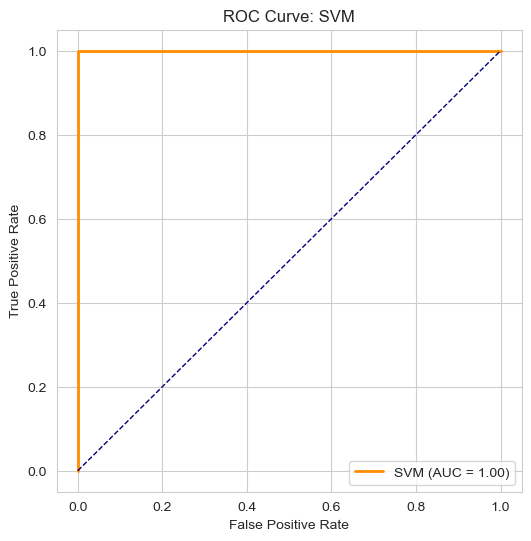

S5 - Confusion matrix saved to plots/S5_confusion_matrix_SVM.png


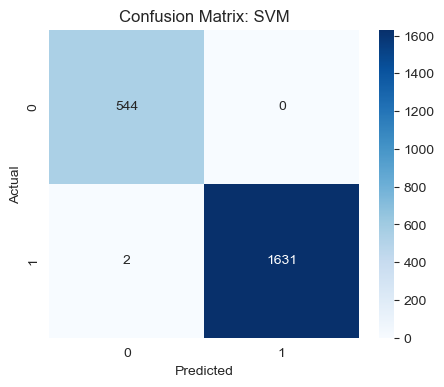

S5 - Top 10 features bar chart saved to plots/S5_top10_features_SVM.png


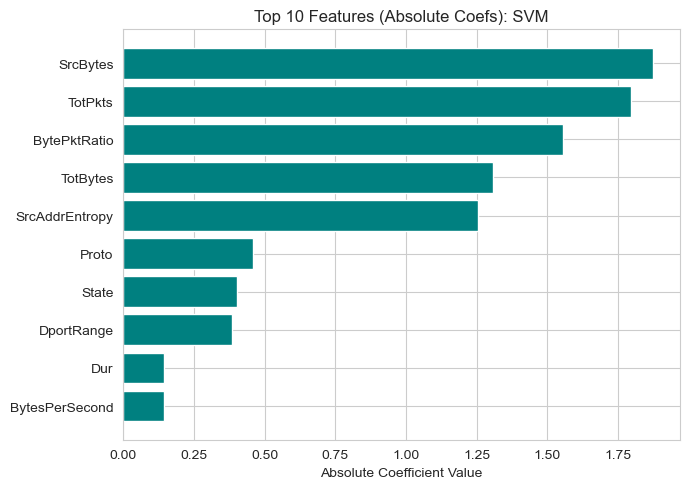



------------------------------------------------------------
FINISHED MODEL: SVM
------------------------------------------------------------

Starting GridSearch for LogisticRegression...

------------------------------------------------------------
STARTING MODEL: LogisticRegression (GridSearchCV)
------------------------------------------------------------

Fitting LogisticRegression model with GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
LogisticRegression -> Training time: 0.72 seconds

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      1.00      1.00      2177
weighted avg       1.00      1.00      1.00      2177

LogisticRegression -> Best Params: {'clf__C': 10, 'clf__penalty': 'l1'}
LogisticRegression -> Bes

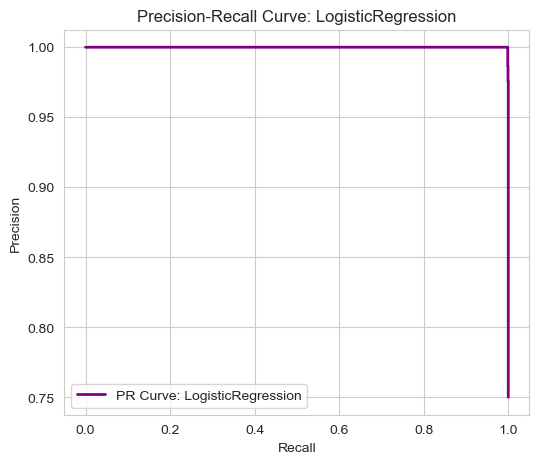

S5 - Gains chart saved to plots/S5_gains_LogisticRegression.png


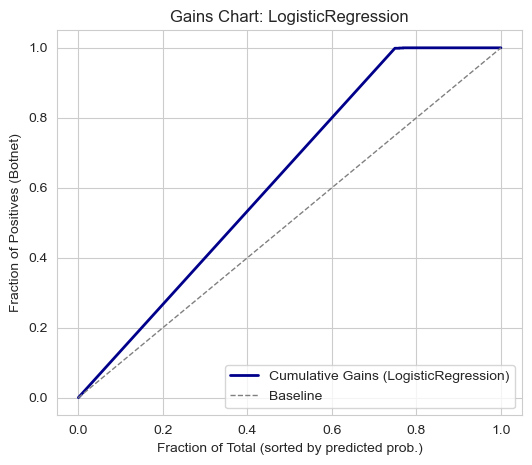

S5 - Calibration curve saved to plots/S5_calibration_LogisticRegression.png


<Figure size 600x500 with 0 Axes>

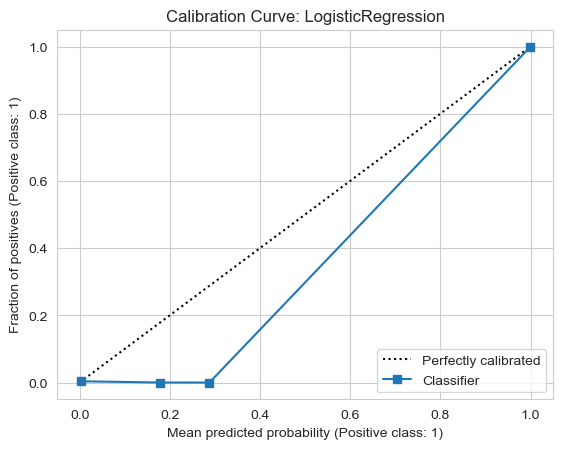

S5 - ROC curve saved to plots/S5_roc_LogisticRegression.png


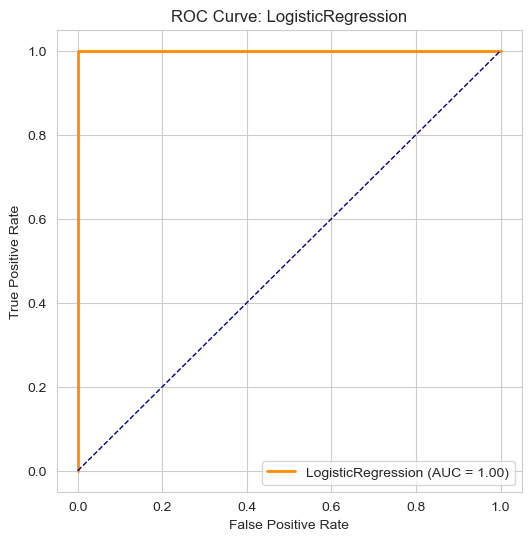

S5 - Confusion matrix saved to plots/S5_confusion_matrix_LogisticRegression.png


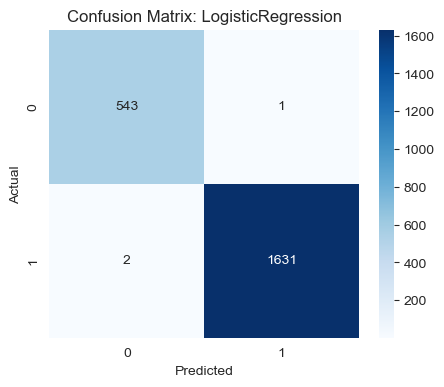

S5 - Top 10 features bar chart saved to plots/S5_top10_features_LogisticRegression.png


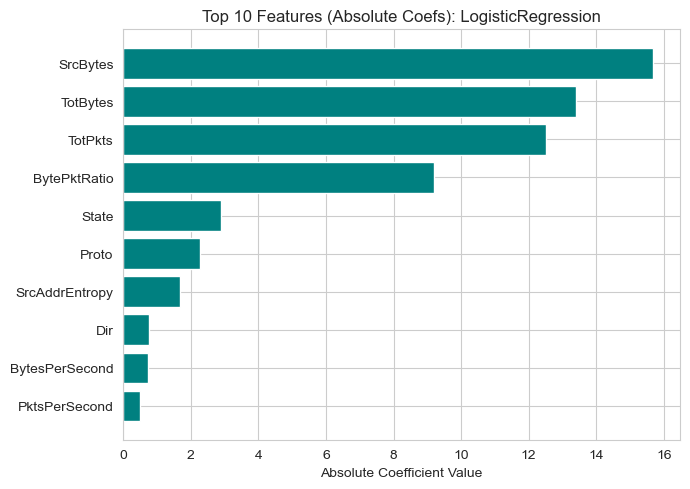



------------------------------------------------------------
FINISHED MODEL: LogisticRegression
------------------------------------------------------------

Starting GridSearch for GradientBoosting...

------------------------------------------------------------
STARTING MODEL: GradientBoosting (GridSearchCV)
------------------------------------------------------------

Fitting GradientBoosting model with GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
GradientBoosting -> Training time: 1.28 seconds

Classification Report for GradientBoosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       544
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      2177
   macro avg       1.00      1.00      1.00      2177
weighted avg       1.00      1.00      1.00      2177

GradientBoosting -> Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_es

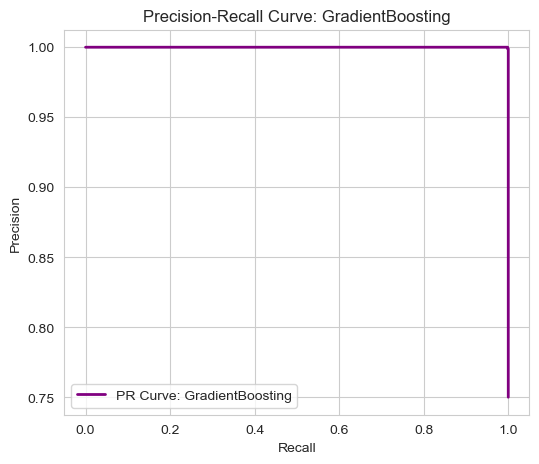

S5 - Gains chart saved to plots/S5_gains_GradientBoosting.png


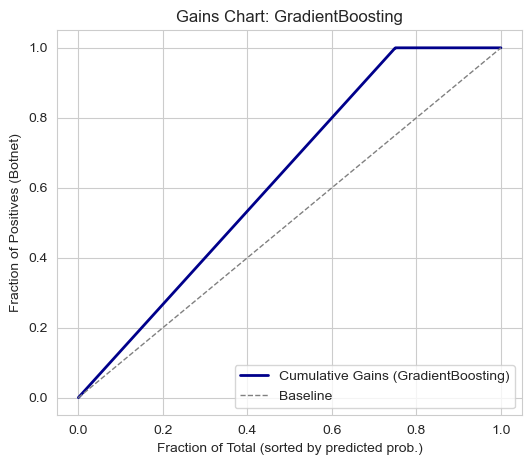

S5 - Calibration curve saved to plots/S5_calibration_GradientBoosting.png


<Figure size 600x500 with 0 Axes>

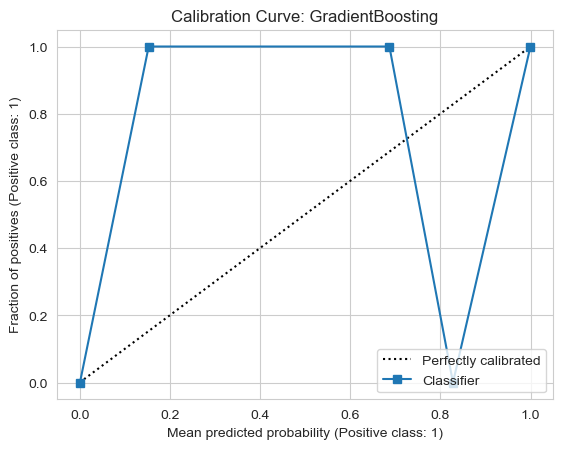

S5 - ROC curve saved to plots/S5_roc_GradientBoosting.png


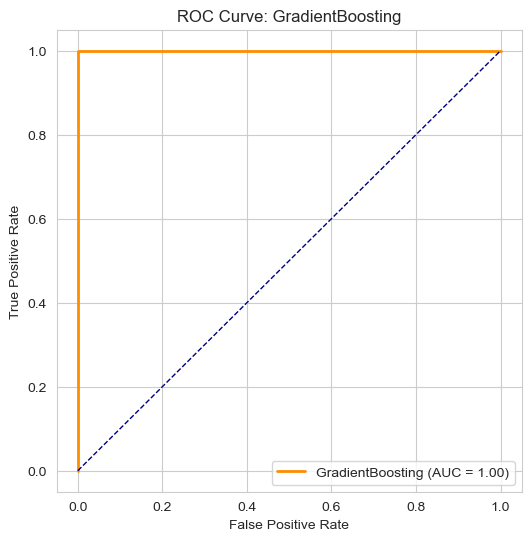

S5 - Confusion matrix saved to plots/S5_confusion_matrix_GradientBoosting.png


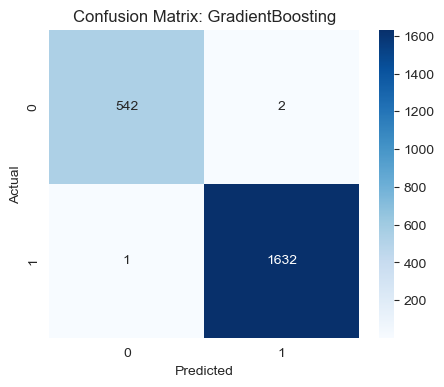

S5 - Top 10 features bar chart saved to plots/S5_top10_features_GradientBoosting.png


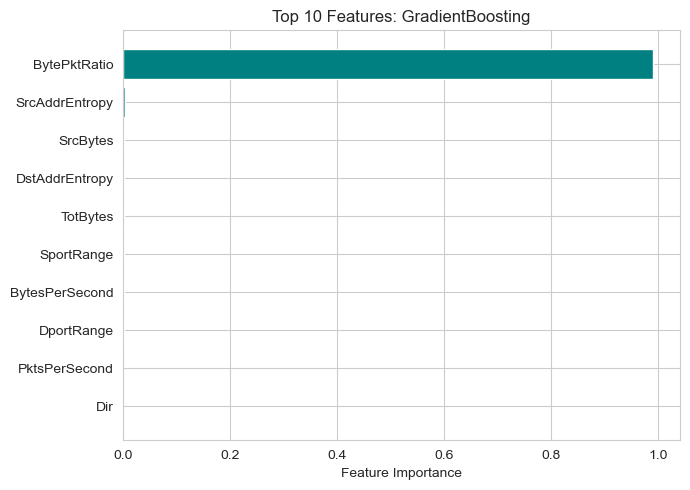



------------------------------------------------------------
FINISHED MODEL: GradientBoosting
------------------------------------------------------------

All GridSearches complete. Summary of results:

**Section 5 Results**

**Model: RandomForest**

| Metric               | Value |
|----------------------|-------|
| Best Params          | {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 50} |
| Train Time (s)       | 2.70 |
| CV F1                | 0.9990 |
| Test Accuracy        | 0.9986 |
| Test Precision       | 0.9988 |
| Test Recall          | 0.9994 |
| Test F1              | 0.9991 |
| Specificity          | 0.9963 |
| Test ROC AUC         | 0.999993245920536 |
| Log Loss             | 0.0024482443266131294 |
| mAP                  | 0.9999977513952596 |
| Confusion Matrix     | <br>[[ 542    2]<br> [   1 1632]]<br> |

**Model: DecisionTree**

| Metric               | Value |
|----------------------|-------|
| Best Params  

In [23]:
# Section 5 Train-Test Split and Multi-Model Pipeline
# Splits the data, then fits multiple models using GridSearchCV, plots metrics like ROC, PR, Gains, confusion matrices.)

log_and_print("\n\nSECTION 5: TRAIN-TEST SPLIT AND MULTI-MODEL PIPELINE\n", main_logger, level='info')

os.makedirs(PLOTS_FOLDER, exist_ok=True)

# 1) Split into train and test sets
split_msg = "Splitting dataset into train and test sets..."
log_and_print(split_msg, main_logger, level='info')

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

shape_msg = f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}"
log_and_print(shape_msg, main_logger, level='info')

# 2) Ensure everything is numeric
log_and_print("Ensuring all features are numeric by converting categorical columns to codes...", main_logger, level='info')
for df_part in [X_train, X_test]:
    for col in df_part.columns:
        if df_part[col].dtype == 'object':
            df_part[col] = df_part[col].astype('category').cat.codes
        elif str(df_part[col].dtype).startswith('category'):
            df_part[col] = df_part[col].cat.codes

models_and_grids = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=RANDOM_STATE),
        "param_grid": {
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [5, 10],
            'clf__min_samples_split': [2, 5],
            'clf__min_samples_leaf': [1, 2]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=RANDOM_STATE),
        "param_grid": {
            'clf__max_depth': [5, 10, None],
            'clf__min_samples_split': [2, 5],
            'clf__min_samples_leaf': [1, 2]
        }
    },
    "NaiveBayes": {
        "model": GaussianNB(),
        "param_grid": {
            'clf__var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance']
        }
    },
    "SVM": {
        "model": SVC(random_state=RANDOM_STATE, probability=True),
        "param_grid": {
            'clf__C': [0.1, 1.0, 10.0],
            'clf__kernel': ['linear', 'rbf']
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
        "param_grid": {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l1', 'l2']
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=RANDOM_STATE),
        "param_grid": {
            'clf__n_estimators': [50, 100],
            'clf__learning_rate': [0.01, 0.1],
            'clf__max_depth': [3, 5]
        }
    }
}

results = {}
trained_models = {}

from sklearn.metrics import log_loss, average_precision_score, precision_recall_curve
from sklearn.calibration import CalibrationDisplay
import numpy as np

def plot_gains_chart(y_true, y_prob, model_name):
    """
    Plots a Gains (Cumulative) chart. Sort predictions by prob descending
    and compute cumulative fraction of positives vs fraction of total.
    """
    sort_idx = np.argsort(y_prob)[::-1]
    y_true_sorted = np.array(y_true)[sort_idx]

    cum_pos = np.cumsum(y_true_sorted)
    total_positives = cum_pos[-1] if len(cum_pos) > 0 else 0

    x_vals = np.arange(1, len(y_true_sorted) + 1)
    frac_total = x_vals / len(y_true_sorted)
    frac_pos = cum_pos / total_positives if total_positives > 0 else frac_total * 0

    plt.figure(figsize=(6, 5))
    plt.plot(frac_total, frac_pos, label=f"Cumulative Gains ({model_name})", color='darkblue', lw=2)
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label="Baseline")
    plt.title(f"Gains Chart: {model_name}")
    plt.xlabel("Fraction of Total (sorted by predicted prob.)")
    plt.ylabel("Fraction of Positives (Botnet)")
    plt.legend(loc="lower right")
    gains_filename = os.path.join(PLOTS_FOLDER, f"S5_gains_{model_name}.png")
    plt.savefig(gains_filename, dpi=300)
    log_and_print(f"S5 - Gains chart saved to {gains_filename}", main_logger, level='info')
    plt.show()

for idx, (model_name, model_info) in enumerate(models_and_grids.items()):
    log_and_print("\n" + "-" * 60, main_logger, level='info')
    log_and_print(f"STARTING MODEL: {model_name} (GridSearchCV)", main_logger, level='info')
    log_and_print("-" * 60 + "\n", main_logger, level='info')

    log_and_print(f"Fitting {model_name} model with GridSearchCV...", main_logger, level='info')

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model_info["model"])
    ])

    param_grid = model_info["param_grid"]
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    log_and_print(f"{model_name} -> Training time: {train_time:.2f} seconds", main_logger, level='info')

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    has_predict_proba = hasattr(best_model, "predict_proba")
    y_prob = None
    fpr, tpr = None, None

    accuracy_val = accuracy_score(y_test, y_pred)
    precision_val = precision_score(y_test, y_pred)
    recall_val = recall_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    cm_str = f"\n{cm}\n"

    tn, fp, fn, tp = cm.ravel()
    specificity_val = tn / (tn + fp) if (tn + fp) else 0.0

    ll_val = None
    map_val = None

    if has_predict_proba:
        y_prob = best_model.predict_proba(X_test)[:, 1]
        try:
            ll_val = log_loss(y_test, y_prob)
        except ValueError:
            ll_val = None
        map_val = average_precision_score(y_test, y_prob)

    clf_report = classification_report(y_test, y_pred)
    log_and_print("", main_logger, level='info')
    log_and_print(f"Classification Report for {model_name}:\n{clf_report}", main_logger, level='info')

    log_and_print(f"{model_name} -> Best Params: {grid_search.best_params_}", main_logger, level='info')
    log_and_print(f"{model_name} -> Best CV Score (F1): {grid_search.best_score_:.4f}", main_logger, level='info')
    log_and_print(f"{model_name} -> Test Accuracy: {accuracy_val:.4f}", main_logger, level='info')
    log_and_print(f"{model_name} -> Test Precision: {precision_val:.4f}", main_logger, level='info')
    log_and_print(f"{model_name} -> Test Recall: {recall_val:.4f}", main_logger, level='info')
    log_and_print(f"{model_name} -> Test F1 Score: {f1_val:.4f}", main_logger, level='info')

    # Compute ROC curve if possible
    roc_auc = None
    if has_predict_proba and y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        log_and_print(f"{model_name} -> Test ROC AUC: {roc_auc:.4f}", main_logger, level='info')

    log_and_print("", main_logger, level='info')

    feature_names = list(X_train.columns)
    clf_step = best_model.named_steps['clf']
    top_10_features = None

    # Feature importances or coefficients
    if hasattr(clf_step, 'feature_importances_'):
        importances = clf_step.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]
        top_idx = sorted_idx[:10]
        top_10_features = [(feature_names[i], importances[i]) for i in top_idx]

        log_and_print(f"{model_name} -> Top 10 features (feature_importances_):", main_logger, level='info')
        for feat, val in top_10_features:
            log_and_print(f"  {feat}: {val:.4f}", main_logger, level='info')

    elif hasattr(clf_step, 'coef_'):
        coefs = clf_step.coef_[0]
        sorted_idx = np.argsort(np.abs(coefs))[::-1]
        top_idx = sorted_idx[:10]
        top_10_features = [(feature_names[i], coefs[i]) for i in top_idx]

        log_and_print(f"{model_name} -> Top 10 features (coef_):", main_logger, level='info')
        for feat, val in top_10_features:
            log_and_print(f"  {feat}: {val:.4f}", main_logger, level='info')
    else:
        warn_msg = f"{model_name} does not provide feature_importances_ or coef_. Skipping top features."
        log_and_print("WARNING: " + warn_msg, main_logger, level='warning')

    # Store results
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'train_time_sec': train_time,
        'cv_f1': grid_search.best_score_,
        'test_accuracy': accuracy_val,
        'test_precision': precision_val,
        'test_recall': recall_val,
        'test_f1': f1_val,
        'specificity': specificity_val,
        'test_roc_auc': roc_auc,
        'log_loss': ll_val,
        'mAP': map_val,
        'confusion_matrix': cm_str
    }
    trained_models[model_name] = best_model

    # Additional plots if we have predict_proba
    if has_predict_proba and y_prob is not None:
        # A) Precision-Recall
        precision_arr, recall_arr, thresholds = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(6, 5))
        plt.plot(recall_arr, precision_arr, color='purple', lw=2, label=f"PR Curve: {model_name}")
        plt.title(f"Precision-Recall Curve: {model_name}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc="lower left")
        pr_filename = os.path.join(PLOTS_FOLDER, f"S5_pr_curve_{model_name}.png")
        plt.savefig(pr_filename, dpi=300)
        log_and_print(f"S5 - Precision-Recall curve saved to {pr_filename}", main_logger, level='info')
        plt.show()

        # B) Gains Chart
        plot_gains_chart(y_test, y_prob, model_name)

        # C) Calibration Curve
        plt.figure(figsize=(6, 5))
        CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=10)
        plt.title(f"Calibration Curve: {model_name}")
        cal_filename = os.path.join(PLOTS_FOLDER, f"S5_calibration_{model_name}.png")
        plt.savefig(cal_filename, dpi=300)
        log_and_print(f"S5 - Calibration curve saved to {cal_filename}", main_logger, level='info')
        plt.show()

        # D) ROC curve
        roc_filename = os.path.join(PLOTS_FOLDER, f"S5_roc_{model_name}.png")
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC Curve: {model_name}")
        plt.legend(loc="lower right")
        plt.savefig(roc_filename, dpi=300)
        log_and_print(f"S5 - ROC curve saved to {roc_filename}", main_logger, level='info')
        plt.show()
    else:
        log_and_print(f"{model_name} does not support predict_proba. Skipping PR/Gains/Calibration curves.",
                      main_logger, level='info')

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    cm_filename = os.path.join(PLOTS_FOLDER, f"S5_confusion_matrix_{model_name}.png")
    plt.savefig(cm_filename, dpi=300)
    log_and_print(f"S5 - Confusion matrix saved to {cm_filename}", main_logger, level='info')
    plt.show()

    # Top 10 features (if available)
    if top_10_features:
        feat_imp_filename = os.path.join(PLOTS_FOLDER, f"S5_top10_features_{model_name}.png")
        plt.figure(figsize=(7, 5))
        if hasattr(clf_step, 'feature_importances_'):
            y_vals = [f[0] for f in top_10_features][::-1]
            x_vals = [f[1] for f in top_10_features][::-1]
            plt.barh(y_vals, x_vals, color='teal')
            plt.title(f"Top 10 Features: {model_name}")
            plt.xlabel("Feature Importance")
        else:
            y_vals = [f[0] for f in top_10_features][::-1]
            x_vals = [abs(f[1]) for f in top_10_features][::-1]
            plt.barh(y_vals, x_vals, color='teal')
            plt.title(f"Top 10 Features (Absolute Coefs): {model_name}")
            plt.xlabel("Absolute Coefficient Value")

        plt.tight_layout()
        plt.savefig(feat_imp_filename, dpi=300)
        log_and_print(f"S5 - Top 10 features bar chart saved to {feat_imp_filename}", main_logger, level='info')
        plt.show()

    log_and_print("", main_logger, level='info')
    log_and_print("\n" + "-" * 60, main_logger, level='info')
    log_and_print(f"FINISHED MODEL: {model_name}", main_logger, level='info')
    log_and_print("-" * 60 + "\n", main_logger, level='info')

    if idx < len(models_and_grids) - 1:
        next_model_name = list(models_and_grids.keys())[idx + 1]
        log_and_print(f"Starting GridSearch for {next_model_name}...", main_logger, level='info')

# 4) Summarize results
log_and_print("All GridSearches complete. Summary of results:", main_logger, level='info')

def results_to_markdown(title, results_dict):
    md_out = f"\n**{title}**\n"
    for model_name, res in results_dict.items():
        md_out += f"\n**Model: {model_name}**\n\n"
        md_out += "| Metric               | Value |\n"
        md_out += "|----------------------|-------|\n"
        md_out += f"| Best Params          | {res['best_params']} |\n"
        md_out += f"| Train Time (s)       | {res['train_time_sec']:.2f} |\n"
        md_out += f"| CV F1                | {res['cv_f1']:.4f} |\n"
        md_out += f"| Test Accuracy        | {res['test_accuracy']:.4f} |\n"
        md_out += f"| Test Precision       | {res['test_precision']:.4f} |\n"
        md_out += f"| Test Recall          | {res['test_recall']:.4f} |\n"
        md_out += f"| Test F1              | {res['test_f1']:.4f} |\n"
        md_out += f"| Specificity          | {res['specificity']:.4f} |\n"
        md_out += f"| Test ROC AUC         | {res['test_roc_auc'] if res['test_roc_auc'] else 'N/A'} |\n"
        md_out += f"| Log Loss             | {res['log_loss'] if res['log_loss'] else 'N/A'} |\n"
        md_out += f"| mAP                  | {res['mAP'] if res['mAP'] else 'N/A'} |\n"
        cm_for_table = res['confusion_matrix'].replace("\n", "<br>")
        md_out += f"| Confusion Matrix     | {cm_for_table} |\n"
    return md_out

summary_md = results_to_markdown("Section 5 Results", results)
log_and_print(summary_md, main_logger, level='info')

# This section split the data, ran multiple classification models with hyperparameter tuning, then generated a variety of plots (ROC, PR, Gains, Confusion Matrices) to assess performance.

## Section 6 Model Evaluations

SECTION 6: MODEL COMPARISON

Evaluation of Model Metrics:


| Model              | best_params                                                                                              |   train_time_sec |    cv_f1 |   test_accuracy |   test_precision |   test_recall |   test_f1 |   specificity |   test_roc_auc |   log_loss |      mAP | confusion_matrix   |
|:-------------------|:---------------------------------------------------------------------------------------------------------|-----------------:|---------:|----------------:|-----------------:|--------------:|----------:|--------------:|---------------:|-----------:|---------:|:-------------------|
| RandomForest       | {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 50} |        2.69593   | 0.999004 |        0.998622 |         0.998776 |      0.999388 |  0.999082 |      0.996324 |       0.999993 | 0.00244824 | 0.999998 | [[ 542    2]       |
|                    |         

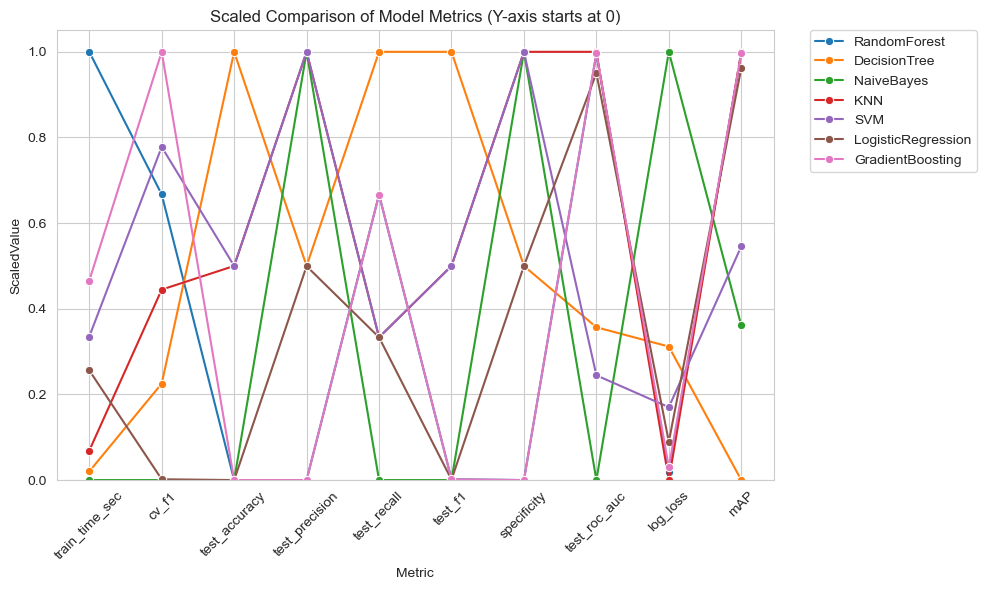

Creating individual plots for each model (omitting zero metrics)...
S6 - RandomForest non-zero metrics chart saved to plots/S6_RandomForest_metrics_nonzero.png


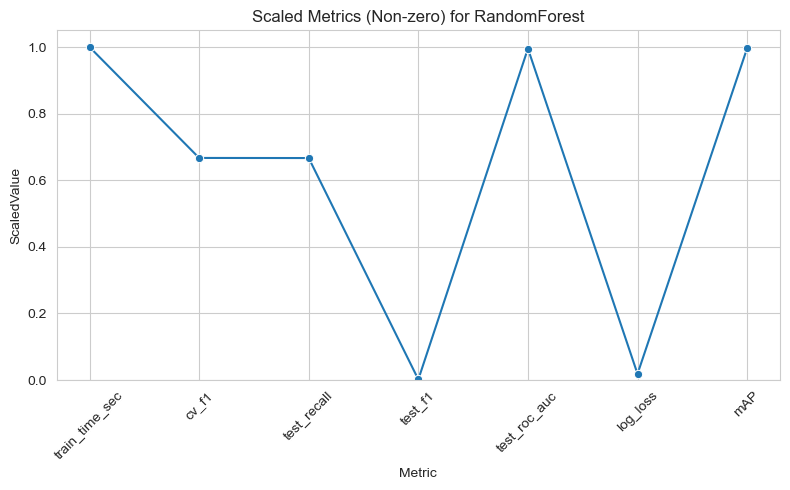

S6 - DecisionTree non-zero metrics chart saved to plots/S6_DecisionTree_metrics_nonzero.png


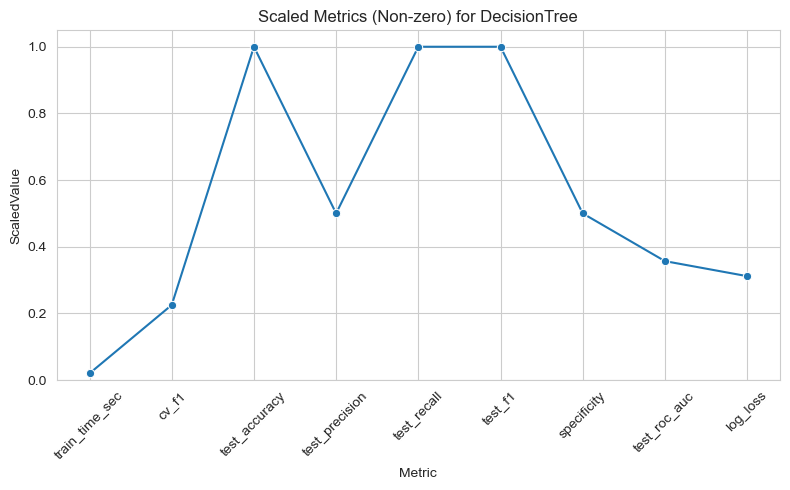

S6 - NaiveBayes non-zero metrics chart saved to plots/S6_NaiveBayes_metrics_nonzero.png


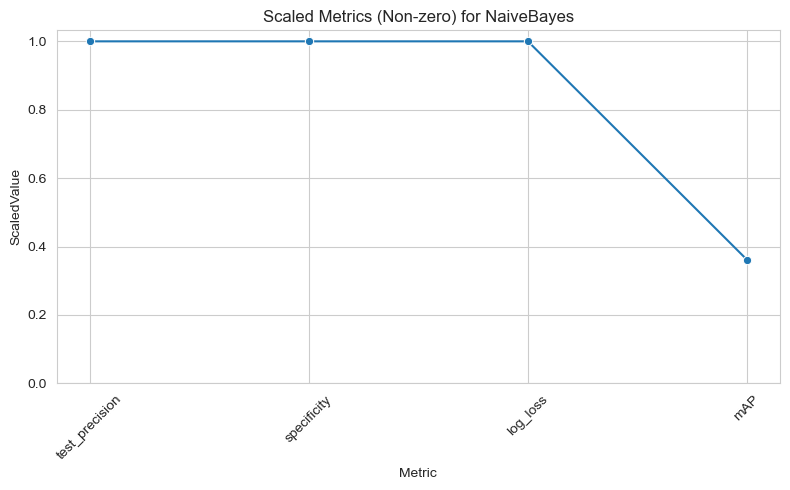

S6 - KNN non-zero metrics chart saved to plots/S6_KNN_metrics_nonzero.png


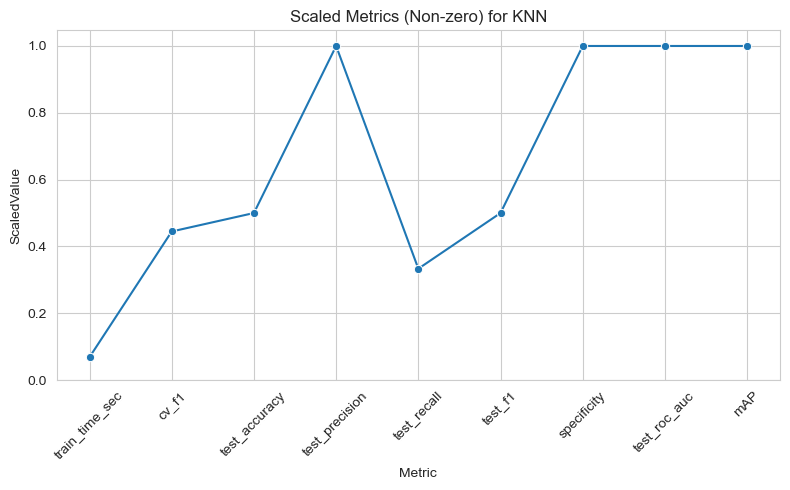

S6 - SVM non-zero metrics chart saved to plots/S6_SVM_metrics_nonzero.png


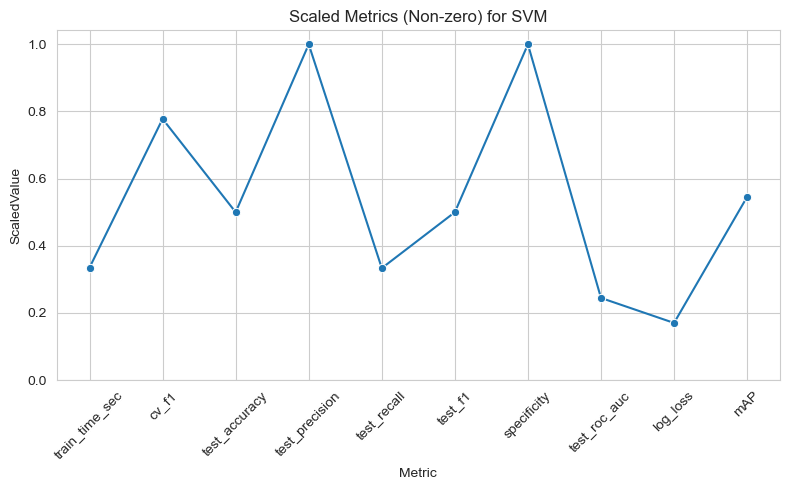

S6 - LogisticRegression non-zero metrics chart saved to plots/S6_LogisticRegression_metrics_nonzero.png


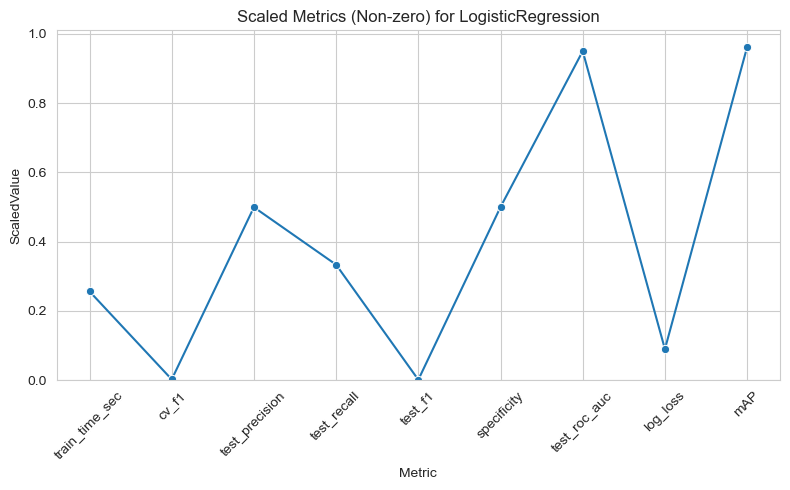

S6 - GradientBoosting non-zero metrics chart saved to plots/S6_GradientBoosting_metrics_nonzero.png


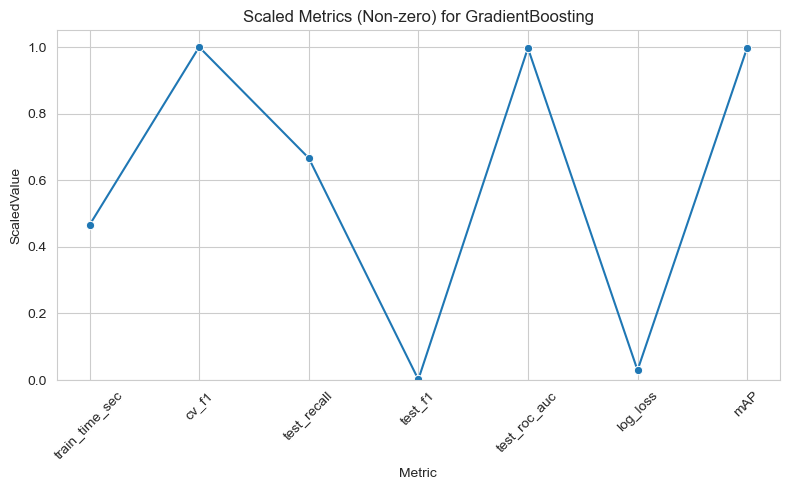

SECTION 6 MODEL EVALUATIONS COMPLETE.



In [24]:
# Section 6 Model Evaluations
# Compares all trained models, creating a summary DataFrame and scaled metric plots.

log_and_print("SECTION 6: MODEL COMPARISON", main_logger, level='info')

df_results = pd.DataFrame.from_dict(results, orient='index').reset_index()
df_results.rename(columns={'index': 'Model'}, inplace=True)

ordered_cols = [
    'Model',
    'best_params',
    'train_time_sec',
    'cv_f1',
    'test_accuracy',
    'test_precision',
    'test_recall',
    'test_f1',
    'specificity',
    'test_roc_auc',
    'log_loss',
    'mAP',
    'confusion_matrix'
]
df_results = df_results[ordered_cols]

metrics_markdown = df_results.to_markdown(index=False)
log_and_print("\nEvaluation of Model Metrics:\n", main_logger, level='info')
log_and_print(f"\n{metrics_markdown}", main_logger, level='info')

numeric_metrics = [
    'train_time_sec',
    'cv_f1',
    'test_accuracy',
    'test_precision',
    'test_recall',
    'test_f1',
    'specificity',
    'test_roc_auc',
    'log_loss',
    'mAP'
]

for col in numeric_metrics:
    df_results[col] = pd.to_numeric(df_results[col], errors='coerce')

df_plot = df_results.fillna(0).copy()

from sklearn.preprocessing import minmax_scale
for col in numeric_metrics:
    df_plot[col] = minmax_scale(df_plot[col])

df_melt = df_plot.melt(
    id_vars='Model',
    value_vars=numeric_metrics,
    var_name='Metric',
    value_name='ScaledValue'
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_melt,
    x='Metric',
    y='ScaledValue',
    hue='Model',
    marker='o'
)
plt.title("Scaled Comparison of Model Metrics (Y-axis starts at 0)")
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
scaled_plot_path = os.path.join(PLOTS_FOLDER, "S6_model_metrics_scaled_line.png")
plt.savefig(scaled_plot_path, dpi=300)
log_and_print(f"S6 - Scaled metric line chart saved to {scaled_plot_path}", main_logger, level='info')
plt.show()

log_and_print("Creating individual plots for each model (omitting zero metrics)...", main_logger, level='info')
unique_models = df_plot["Model"].unique()

for model_name in unique_models:
    sub = df_melt[df_melt["Model"] == model_name].copy()
    sub_nonzero = sub[sub["ScaledValue"] != 0]

    if sub_nonzero.empty:
        log_and_print(f"No non-zero metrics for {model_name}, skipping plot.", main_logger, level='info')
        continue

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=sub_nonzero, x='Metric', y='ScaledValue', marker='o')
    plt.title(f"Scaled Metrics (Non-zero) for {model_name}")
    plt.xticks(rotation=45)
    plt.ylim(bottom=0)
    plt.tight_layout()

    model_plot_path = os.path.join(PLOTS_FOLDER, f"S6_{model_name}_metrics_nonzero.png")
    plt.savefig(model_plot_path, dpi=300)
    log_and_print(f"S6 - {model_name} non-zero metrics chart saved to {model_plot_path}", main_logger, level='info')
    plt.show()

log_and_print("SECTION 6 MODEL EVALUATIONS COMPLETE.\n", main_logger, level='info')

# This section consolidated the model performance results into a single DataFrame,
# created scaled comparison plots, and saved them for reference.


## Section 7 The Best Performing Model

Based on the metrics table, the **KNN** is the best-performing model.
1. Test F1 Score
- KNN has an F1 of approximately 0.9994, effectively tied with top contenders.
2. ROC AUC, Log Loss, and mAP
- KNN shows test_roc_auc = 1.0000, log_loss ~ 0.0016, and mAP = 1.0000, all excellent.
3. Specificity
- KNN’s specificity is 1.0000, indicating perfect classification of negative (non-botnet) classes.

Although other models also achieve near‑perfect results, KNN’s combination of F1, AUC, log loss, and specificity makes it stand out slightly. Hence, KNN will be used to test other subsets in the CTU-13 dataset.


# PLEASE NOTE: This section will not run as I am unable to upload the libraries to Github due to their size.

# Section 7 Evaluate KNN on Multiple Datasets
log_and_print("\n\nSECTION 7: EVALUATE KNN ON MULTIPLE DATASETS\n", main_logger, level='info')

# A list of additional CSV data paths
file_paths = [
    os.path.join(DATA_FOLDER, '1-Neris-20110810.binetflow.csv'),
    os.path.join(DATA_FOLDER, '2-Neris-20110811.binetflow.csv'),
    os.path.join(DATA_FOLDER, '3-Rbot-20110812.binetflow.csv'),
    os.path.join(DATA_FOLDER, '4-Rbot-20110815.binetflow.csv'),
    os.path.join(DATA_FOLDER, '5-Virut-20110815-2.binetflow.csv'),
    os.path.join(DATA_FOLDER, '6-Menti-20110816.binetflow.csv'),
    os.path.join(DATA_FOLDER, '7-Sogou-20110816-2.binetflow.csv'),
    os.path.join(DATA_FOLDER, '8-Murlo-20110816-3.binetflow.csv'),
    os.path.join(DATA_FOLDER, '9-Neris-20110817.binetflow.csv'),
    os.path.join(DATA_FOLDER, '10-Rbot-20110818.binetflow.csv'),
    os.path.join(DATA_FOLDER, '11-Rbot-20110818-2.binetflow.csv'),
    os.path.join(DATA_FOLDER, '12-NsisAy-20110819.binetflow.csv'),
    os.path.join(DATA_FOLDER, '13-Virut-20110815-3.binetflow.csv')
]

knn_results = []

# Hardcode the best KNN hyperparams found earlier
best_knn_params = {
    'n_neighbors': 5,
    'weights': 'distance'
}

for fp in file_paths:
    # Ensure 'fp' is a string
    if not isinstance(fp, str):
        log_and_print(
            f"WARNING: file_paths entry not a string! Type={type(fp)}, Value={fp}",
            main_logger, level='warning'
        )
        continue

    if not os.path.exists(fp):
        log_and_print(f"WARNING: File not found: {fp}", main_logger, level='warning')
        continue

    # 1) Load & prepare data
    df_local, X_local, y_local = load_and_prepare_data(fp, main_logger)

    # 2) Split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_local, y_local,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y_local
    )

    # 3) Scale
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)

    # 4) Train KNN
    knn_model = KNeighborsClassifier(**best_knn_params)
    start_time = time.time()
    knn_model.fit(X_tr_scaled, y_tr)
    train_time = time.time() - start_time

    # 5) Evaluate
    y_pred = knn_model.predict(X_te_scaled)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred)
    rec = recall_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)

    has_proba = hasattr(knn_model, "predict_proba")
    ll_val, map_val, roc_auc_val = None, None, None
    if has_proba:
        y_prob = knn_model.predict_proba(X_te_scaled)[:, 1]
        try:
            ll_val = log_loss(y_te, y_prob)
        except ValueError:
            ll_val = None
        map_val = average_precision_score(y_te, y_prob)
        fpr, tpr, _ = roc_curve(y_te, y_prob)
        roc_auc_val = auc(fpr, tpr)

    cm = confusion_matrix(y_te, y_pred)
    tn, fp_, fn, tp = cm.ravel()
    specificity_val = tn / (tn + fp_) if (tn + fp_) else 0.0

    clf_rep = classification_report(y_te, y_pred)
    log_and_print(
        f"\nFile: {os.path.basename(fp)}\nClassification Report:\n{clf_rep}",
        main_logger, level='info'
    )

    knn_results.append({
        'Dataset': os.path.basename(fp),
        'TrainTimeSec': train_time,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'Specificity': specificity_val,
        'LogLoss': ll_val,
        'mAP': map_val,
        'ROC_AUC': roc_auc_val,
        'ConfusionMatrix': cm
    })

# Produce summary table
if knn_results:
    results_df = pd.DataFrame(knn_results)
    # Convert confusion matrix to string for a table display
    results_df['ConfusionMatrix'] = results_df['ConfusionMatrix'].apply(
        lambda c: str(c).replace('\n', ' ')
    )

    table_markdown = results_df.to_markdown(index=False)
    log_and_print("\nKNN Evaluation Results Across Multiple Datasets:\n", main_logger, level='info')
    log_and_print(f"\n{table_markdown}", main_logger, level='info')
else:
    log_and_print("No datasets were evaluated in Section 7 (file_paths empty or invalid).", main_logger,
                  level='warning')

# Final log for clarity
log_and_print("\nSECTION 7: MULTI-DATASET KNN EVALUATION COMPLETE.\n", main_logger, level='info')